In [5]:
# test script that puts it all together
import os
os.chdir('..')
print(os.getcwd())

D:\git


In [6]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt

# User Interface: Selecting targets by driving a dynamical system into low-energy states

To illustrate how active inference can help adapt parameters of complex user interfaces to improve performance, we explore a target selection task with artificially complicated but well understood interaction dynamics. A visual display shows $N$ targets in motion mimicking the harmonic oscillation of masses on springs. All springs are *anchored* at the same height to a horizontal line that is controlled by the user. Each target has a different parametrization corresponding to different oscillation frequencies. A target is selected by reducing its mechanical energy to fall below some threshold $\tau$ while keeping all other targets' mechanical energies above the threshold. The mechanical energy is defined as the sum of potential energy and kinetic energy, with all energy being kinetic at the zero crossing and all energy being potential at the oscillation extrema. The oscillation amplitude thereby gives the user feedback about the effect of their inputs on progress towards selecting individual targets. Moving the anchor towards or away from a target reduces or increase its potential energy, respectively.

The harmonic oscillators act as a common mediating mechanism between various input spaces (e.g., trajectories of a mouse pointer, a visually tracked hand, gaze, or device tilting movements) and the control space (one of $N$ target selection). By decoupling the interaction metaphor from the specific input modality we can leverage users' mental model of the dynamics to make control across multiple modalities more intuitive, provided that parametrisations of the dynamics can be found that work well for each modality and user. Traditionally, finding good parametrisations was done manually or through trial and error user testing in each new context. More recently, computational interaction methods have been proposed, where user models trained via reinforcement learning are used to evaluate individual interface parametrisations in simulation  off-line. Here, we set out to demonstrate how active inference can be used to simultaneously learn the user model and adapt interface parametrisations to optimize task performance on-line, i.e. while a user interacts with the system.

## Harmonic Oscillators

### Mathematical description

We parametrise each harmonic oscillator with a mass $m$ and a spring constant $\kappa$, which correspond to the oscillation frequency in Eq. X
$$f=\frac{1}{2\pi}\sqrt{\frac{\kappa}{m}}$$

The state is represented by $(x, \dot x)$ , where $x$ is its distance from the anchor and $\dot x$ its velocity. The mechanical energy $E$, potential energy $U$, and kinetic energy $K$ are defined as in Eq. X
$$
E = U + K 
$$
$$ U = \frac{1}{2}\kappa \cdot x^2 $$
$$ K = \frac{1}{2}m \cdot \dot x^2 $$

The dynamics are described by an ordinary differential equation (ODE) and state updates are performed by taking one Euler step of length $dt$ (see Eq. X)

$$ \ddot x = \frac{F}{m} = \frac{-\kappa \cdot \dot x_t}{m} $$
$$ \dot x_t = \dot x_{t-1} + dt \cdot \ddot x_t $$
$$ x_t = x_{t-1} + dt \cdot \ \dot x_t$$

### Implementation

In [7]:
class HarmonicOscillator():
    
    def __init__(self, 
                 N=1, 
                 mass=1., 
                 spring_constant=1., 
                 damping_coefficient=0., 
                 dt=0.1, 
                 energy_start=1., 
                 energy_max=2):
      # config
      self.N = N
      self.mass_start = mass
      self.spring_start = spring_constant
      self.damping_start = damping_coefficient
      self.dt = dt # Euler step length
      self.energy_start = energy_start
      self.energy_max = energy_max
      # state
      self.mass = None
      self.spring = None
      self.damping = None
      self.x = None
      self.v = None
      self.anchor = 0
      
    def copy(self):
      other = HarmonicOscillator(N=self.N,
                                 mass=self.mass_start,
                                 spring_constant=self.spring_start,
                                 damping_coefficient=self.damping_start,
                                 dt=self.dt,
                                 energy_start=self.energy_start,
                                 energy_max=self.energy_max)
      other.mass = None if self.mass is None else self.mass.copy()
      other.spring = None if self.spring is None else self.spring.copy()
      other.damping = None if self.damping is None else self.damping.copy()
      other.x = None if self.x is None else self.x.copy()
      other.v = None if self.v is None else self.v.copy()
      other.anchor = self.anchor
      return other               
      
    def frequency(self):
      return 1/(2*np.pi) * np.sqrt(self.spring / self.mass)
    
    def set_frequency(self, f, atol=1e-2):
      # update spring constant to change frequency
      # - skip update where current frequency is within tolerance of target
      do_update = np.abs(f - self.frequency()) > atol
      e_before = self.energy()
      ratio = (2*np.pi*f)**2
      self.spring = do_update * ratio * self.mass_start + (1-do_update) * self.spring
      # update spring constant and mass to reset energy
      factor = e_before/self.energy()
      self.spring = self.spring * factor * do_update + (1-do_update) * self.spring
      self.mass = self.mass * factor * do_update + (1-do_update) * self.mass
      
    def set_energy(self, energy):
      # update position and velocity to change energy
      u = self.potential_energy()
      k = self.kinetic_energy()
      factor = energy / (u+k)
      dx = self.x - self.anchor
      self.x = np.sqrt(2 * u * factor / self.spring) * np.sign(dx) + self.anchor
      self.v = np.sqrt(2 * k * factor / self.mass) * np.sign(self.v)
    
    def potential_energy(self, x=None, spring=None):
      x = self.x if x is None else x
      dx = x - self.anchor
      spring = self.spring if spring is None else spring
      return 0.5 * spring * dx**2
    
    def kinetic_energy(self, v=None, mass=None):
      v = self.v if v is None else v
      mass = self.mass if mass is None else mass
      return 0.5 * mass * v**2
    
    def energy(self, x=None, v=None, spring=None, mass=None):
      return self.potential_energy(x, spring) + self.kinetic_energy(v, mass)
    
    def ddot_x(self, dx, v=None, spring=None, damping=None, mass=None):
      v = self.v if v is None else v
      spring = self.spring if spring is None else spring
      damping = self.damping if damping is None else damping
      mass = self.mass if mass is None else mass
      
      f_spring = -spring * dx # reduced spring should reduce spring force
      f_friction = -damping * v
      f_total = f_spring + f_friction
      a = f_total / mass # reduced mass should increase acceleration
      return a
    
    def reset(self):
      # self.anchor = self.anchor_start
      self.mass = self.mass_start * np.ones(self.N)
      self.spring = self.spring_start * np.ones(self.N)
      self.damping = self.damping_start * np.ones(self.N)
      
      # initialise all targets with equal energy and different phase
      phase = np.linspace(0, 2*np.pi, self.N+1)[:-1]
      e = self.energy_start # total mechanical energy
      max_x = np.sqrt(2*e/self.spring) # amplitude along x
      self.x = max_x * np.sin(phase) + self.anchor
      # note: maximum avoids numerical instability near zero in sqrt
      k = np.maximum(0, e - self.potential_energy())
      self.v = np.sqrt(2*k/self.mass) * np.sign(np.cos(phase))
      return {'x': self.x, 'v': self.v, 'energy': self.energy(),
              'debug': {'mass': self.mass, 'spring': self.spring}
              }
    
    def step(self, action=0):
      # make hypothetical step with original parameters
      self.anchor = action
      dx = self.x - self.anchor
      a = self.ddot_x(dx)
      self.v = self.v + self.dt * a
      self.x = self.x + self.dt * self.v
      
      # boundary condition: limit energy
      e = self.energy()
      self.set_energy(np.minimum(e, self.energy_max))
      
      return {'x': self.x, 'v': self.v, 'energy': self.energy(), 
              'debug': {'mass': self.mass, 'spring': self.spring}
             }
    
    def plot_phase_space(self, axis=None):
      if axis is None:
        _, axis = plt.subplots()
      num_steps = int(np.max(1/(self.frequency() * self.dt))) + 2
      outputs = ['x', 'v']
      if self.x is None:
        self.reset()
      
      states = {o: [] for o in outputs}
      for _ in range(num_steps):
        state = self.step()
        for o in outputs:
          states[o].append(state[o])
      
      plt.sca(axis)
      plt.plot(np.array(states['x']), np.array(states['v']), '-')
      plt.title('Phase space');
      plt.xlabel('$x$')
      plt.ylabel("$\dot x$")
        

### Simulations

#### Single target with instantaneous intervention on frequency and energy

Here we simulate the dynamics of one harmonic oscillator over time with an instantaneous intervention on its frequency and energy at time $t=1000$.

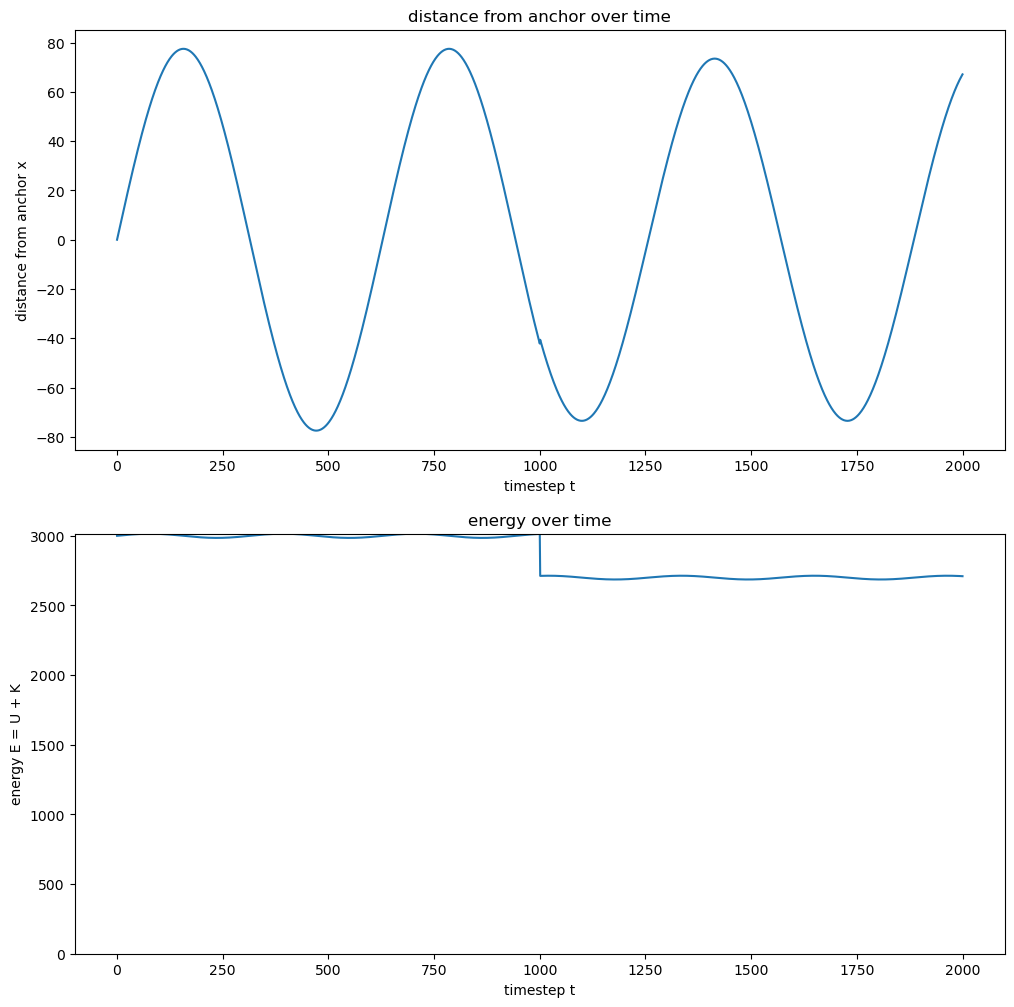

In [18]:
# Simulate uncontrolled oscillation
num_steps = 2_000
agent = HarmonicOscillator(N=1, dt=0.01, energy_start=3e3, energy_max=6e3)
agent.reset()
#agent.plot_phase_space()

os = [agent.reset()]
for i in range(num_steps):
  if i == 1_000:
    f = agent.frequency()
    e = agent.energy()
    
    #agent.set_frequency(f*2.)
    agent.set_energy(e*0.9)
    
  os.append(agent.step())

fig, axes = plt.subplots(2, 1, figsize=(2*6, 12))

plt.sca(axes[0])
plt.title('distance from anchor over time')
xs = [o['x'] for o in os]
plt.plot(xs)
plt.ylabel('distance from anchor x')
plt.xlabel('timestep t')

plt.sca(axes[1])
plt.title('energy over time')
es = [o['energy'] for o in os]
plt.plot(es)
plt.ylabel('energy E = U + K')
plt.xlabel('timestep t')
plt.ylim([0, np.max(es)]);


#### Multiple targets

Text(0, 0.5, 'x')

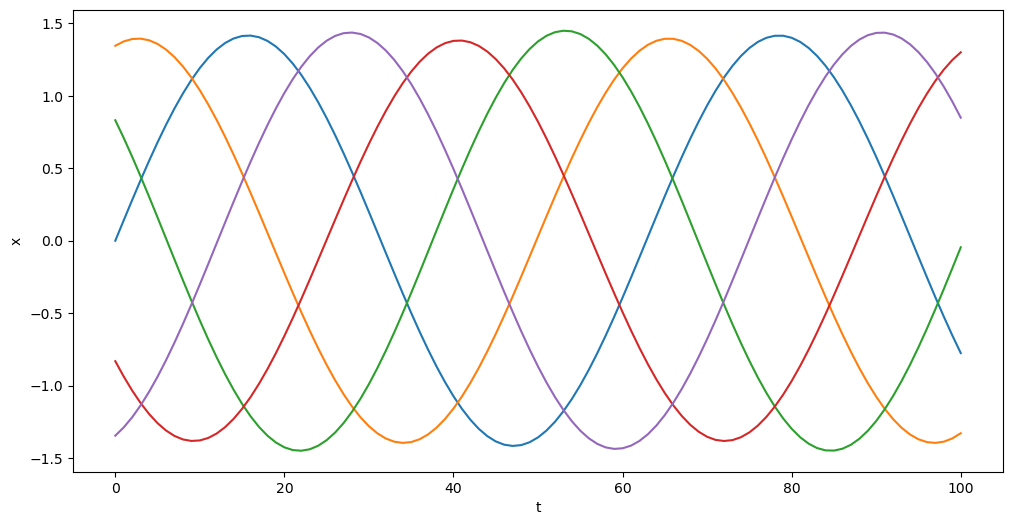

In [16]:
# simulate dynamics of oscillators with different parameters and different energy
num_objects = 5
agent = HarmonicOscillator(N=num_objects)

fig, axes = plt.subplots(figsize=(12, 6))
xs = [agent.reset()['x']]
for _ in range(100):
  xs.append(agent.step()['x'])
  
plt.sca(axes)
plt.plot(xs);
plt.xlabel('t')
plt.ylabel('x')

# Optimal Behaviour and User Modelling

Optimal user behaviour reduces a target's energy most rapidly. This involves exactly tracking the target's position, instantly absorbing all potential energy as it is converted from kinetic energy. In practice real users have limited precision and act with delays, both present in their visual perception, cognitive process, and motor execution. To capture delays and limited precision, we model user input as a first-order lag with Gaussian noise.

## Simulated User

### First Order Lag - Implementation and Simulation with a Periodic Step Function

We account for perceptual, cognitive and motor delays by modelling the user with a first-order lag.

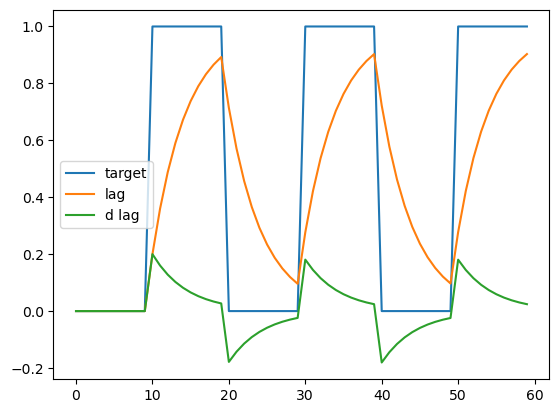

In [10]:
# 2. Wrap behavior in an agent class.
class FirstOrderLag:
  """"
  First order lag (vectorized).
  
  Args:
      conductivity (np.array): moving average weight of new input, in [0,1].
      s0 (np.array): initial state after reset. 
      bounds (np.array): minimum and maximum state values
  """
  
  def __init__(self, conductivity=0.5, s0=0, bounds=None):
    # config
    self.k = conductivity
    self.s0 = s0
    self.bounds = bounds
    # state
    self.s = None
    
  def copy(self):
    other = FirstOrderLag(conductivity=self.k,
                          s0=self.s0,
                          bounds=self.bounds)
    other.s = None if self.s is None else self.s.copy()
    return other
    
  def reset(self):
    self.s = np.copy(self.s0)
    self.s = self._clip(self.s)
    return {'x': self.s, 'dx': np.zeros_like(self.s)}
  
  def step(self, u):
    s = (1-self.k) * self.s + self.k * u
    s = self._clip(s)
    ds = s - self.s
    self.s = s
    return {'x': self.s, 'dx': ds}
  
  def _clip(self, s):
    if self.bounds is None:
      return s
    
    return np.clip(s, self.bounds[0], self.bounds[1])
  
# control signal u
num_repetitions = 3
num_steps_per_phase = 10
u = np.hstack([np.zeros((num_repetitions, num_steps_per_phase)), np.ones((num_repetitions, num_steps_per_phase))]).reshape(-1)
  
lag = FirstOrderLag(conductivity=0.2)
lag.reset()
y = [lag.step(u[t]) for t in range(u.shape[0])]
plt.plot(u, label='target')
plt.plot([y['x'] for y in y], label='lag')
plt.plot([y['dx'] for y in y], label='d lag')
plt.legend()

### Gaussian Noise - Implementation and Simulation with a Periodic Step Function

We account for users' perceptual and motor precision with additive Gaussian noise.

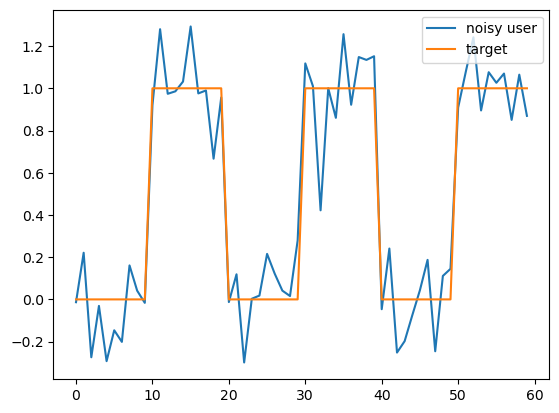

In [11]:
class Gaussian:
  """ Gaussian agent. Adds Gaussian noise to its input. """
  def __init__(self, rng, stdev=1., a0=0, mode='additive'):
    # config
    self.rng = rng
    self.stdev = stdev
    self.a0 = a0 # assumed starting input
    self.mode = mode # {'additive', 'scaled'}
    self.sample = self._sample_additive
    if self.mode == 'multiply':
      self.sample = self._sample_multiplicative
      
  def copy(self):
    return Gaussian(self.rng, self.stdev, self.a0, self.mode)
    
  def reset(self):
    return self.sample(self.a0)
  
  def step(self, a):
    return self.sample(a)
  
  def _sample_additive(self, a):
    return a + self.rng.normal(size=np.asarray(a).shape) * self.stdev
  
  def _sample_multiplicative(self, a):
    return a * self.rng.normal(size=np.asarray(a).shape) * self.stdev

  
gaussian = Gaussian(rng=rng, stdev=0.2, a0=0, mode='additive')
xs = [gaussian.step(u[t]) for t in range(u.shape[0])]
plt.plot(xs, label='noisy user');
plt.plot(u, label='target');
plt.legend()

### Noisy Lag - Combining First-order Lag with Gaussian Noise

The simulated user is represented by a composition of first-order lag and Gaussian noise.

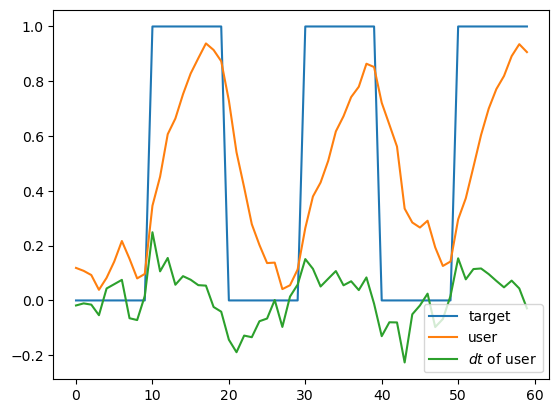

In [19]:
class NoisyLag:
  """ 
  First-order lag on noisy observations. 
  Used as a model for user input. 
  """
  
  def __init__(self, noise, lag):
    # config
    self.noise = noise
    self.lag = lag
    
  def copy(self):
    other = NoisyLag(None, None)
    other.noise = self.noise.copy()
    other.lag = self.lag.copy()
    return other
    
  def reset(self):
    # treat lag value as noisy observation of the state
    x = self.lag.reset()['x']
    x_noisy = self.noise.step(x)
    self.lag.s = self.lag._clip(x_noisy)
    return {'x': x_noisy, 'dx': 0}
    
  def step(self, action):
    # noisy percept of true position
    x_noisy = self.noise.step(action)
    # tracking perceived position
    return self.lag.step(x_noisy)
    
lag = FirstOrderLag(conductivity=0.2)
noise = Gaussian(stdev=0.2, rng=rng)
user = NoisyLag(lag=lag, noise=noise)

user.reset()
y = [user.step(u[t]) for t in range(u.shape[0])]
plt.plot(u, label='target')
plt.plot([y['x'] for y in y], label='user')
plt.plot([y['dx'] for y in y], label='$dt$ of user')
plt.legend()

## Closed-loop Feedback Control

### Single object to control

Let's start building a closed-loop interactive system where the _User_, the _App_ and their _Interaction_ are modeled as hierarchies of agents. This may seem somewhat over the top for now, but will become increasingly valuable as we build out the logic for both the agent and the app.

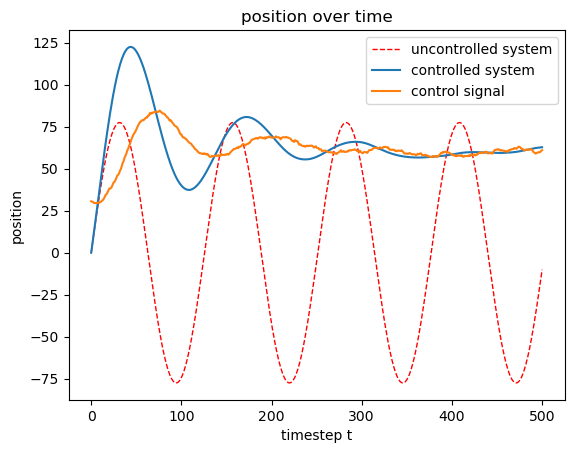

In [13]:
# 6. simulate MassSpringDamper controlled by FirstOrderLag
class AppA:
  # thin wrapper around the app; this will contain more complex logic below
  def __init__(self, num_targets=1, dt=0.1):
    self.targets = HarmonicOscillator(N=num_targets, dt=dt, energy_start=3e3, energy_max=6e3)
    
  def reset(self):
    return {'targets': self.targets.reset()}
  
  def step(self, action={'x': 0}):
    return {'targets': self.targets.step(action['x'])}
  
  
class UserA:
  # noisy lag of a specified target; we'll expand on this with a random
  # target generator below.
  def __init__(self, target=0, conductivity=0.2, noise_scale=1.0, rng=rng):
    self.target = target
    
    self.lag = FirstOrderLag(conductivity=conductivity, s0 = np.zeros(1))
    self.noise = Gaussian(stdev=noise_scale, rng=rng)
    self.motor = NoisyLag(lag=self.lag, noise=self.noise)
    
  def reset(self):
    return self.motor.reset()
  
  def step(self, observation):
    return self.motor.step(observation['targets']['x'][self.target])
  
  
class Interaction:
  # interface between the app and the user, represented as a composite agent
  def __init__(self, app, user):
    self.app = app
    self.user = user
    
  def reset(self):
    return {'app': self.app.reset(),
         'user': self.user.reset()}
  
  def step(self, last_state):
    o = {}
    o['app'] = self.app.step(last_state['user'])
    o['user'] = self.user.step(o['app'])
    return o


num_steps = 5_00

app = AppA(dt=0.05)
user = UserA(conductivity=0.02, noise_scale=20.0)
system = Interaction(user=user, app=app)

# generate an uncontrolled sequence as baseline
app.reset()
xs_uncontrolled = [app.reset()['targets']['x']] + [app.step()['targets']['x'] for _ in range(num_steps)]

# simulate closed-loop
os = [system.reset()]
for i in range(num_steps):
  os.append(system.step(os[-1]))

plt.plot(np.array(xs_uncontrolled)[:,user.target], 'r--', linewidth=1., label='uncontrolled system')
plt.plot([o['app']['targets']['x'] for o in os], label='controlled system')
plt.plot([o['user']['x'] for o in os], label='control signal')
plt.title('position over time')
plt.xlabel('timestep t')
plt.ylabel('position')
plt.legend()

### Selective Control

Text(0.5, 0, 'timestep t')

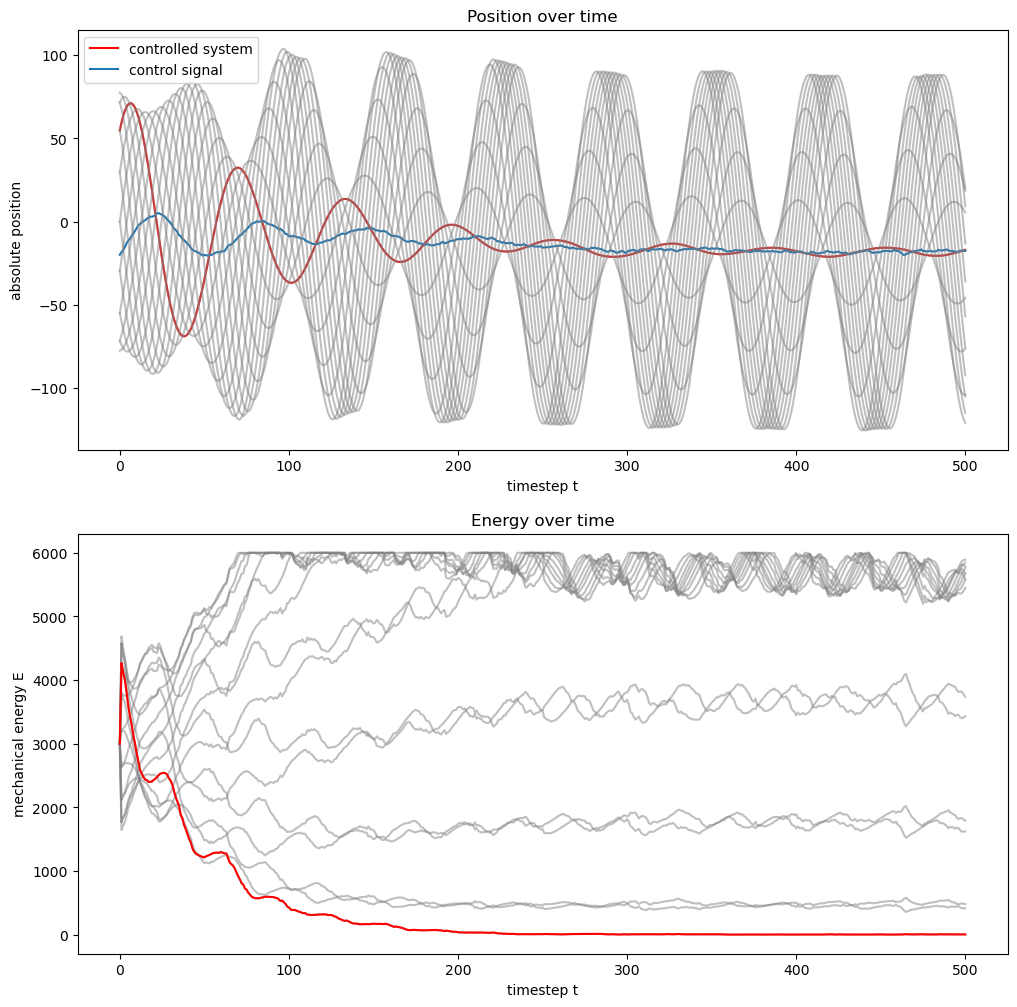

In [14]:
# 7. simulate a set of MassSpringDampers with different mass and selective control with FirstOrderLag
num_steps = 5_00
num_targets = 16
user_target = 2

app = AppA(num_targets=num_targets)
user = UserA(target=user_target, conductivity=0.02, noise_scale=20.0)
system = Interaction(user=user, app=app)
# generate an uncontrolled sequence as baseline
app.reset()
xs_uncontrolled = [app.reset()['targets']['x']] + [app.step()['targets']['x'] for _ in range(num_steps)]
# simulate closed-loop
os = [system.reset()]
for i in range(num_steps):
  os.append(system.step(os[-1]))

fig, ax = plt.subplots(2, 1, figsize=(2*6, 12))

plt.sca(ax[0])
plt.title('Position over time')
xs = [o['app']['targets']['x'] for o in os]

#plt.plot(np.array(xs_uncontrolled)[:,user_target], 'r--', linewidth=1., label='uncontrolled system')
plt.plot(np.array(xs)[:,user_target], 'r', label='controlled system')
plt.plot([o['user']['x'] for o in os], label='control signal')
plt.plot(xs, 'gray', alpha=0.5)
plt.xlabel('timestep t')
plt.ylabel('absolute position')
plt.legend()

plt.sca(ax[1])
plt.title('Energy over time')
es = [o['app']['targets']['energy'] for o in os]
plt.plot(es, 'gray', alpha=0.5)
plt.plot(np.array(es)[:,user_target], 'r')
plt.ylabel('mechanical energy E')
plt.xlabel('timestep t')

### Selection Trigger

This section develops the mechanism within the app that triggers events associated with oscillating targets. Conceptually, an event should be triggered once an oscillating target's energy has been reduced to fall below a threshold. Practically, we need to consider false positive events triggered by transient low-energy objects. To address this, we use a filtered version of the energy as input to the treshold, where the filter is a first-order lag with conductivity that is than the assumed model user.

As the number of targets increases
- the threshold needs lowered
- the EMA conductivity needs to be reduced


#### `class App`

Text(0.5, 1.0, 'smoothed energy over time')

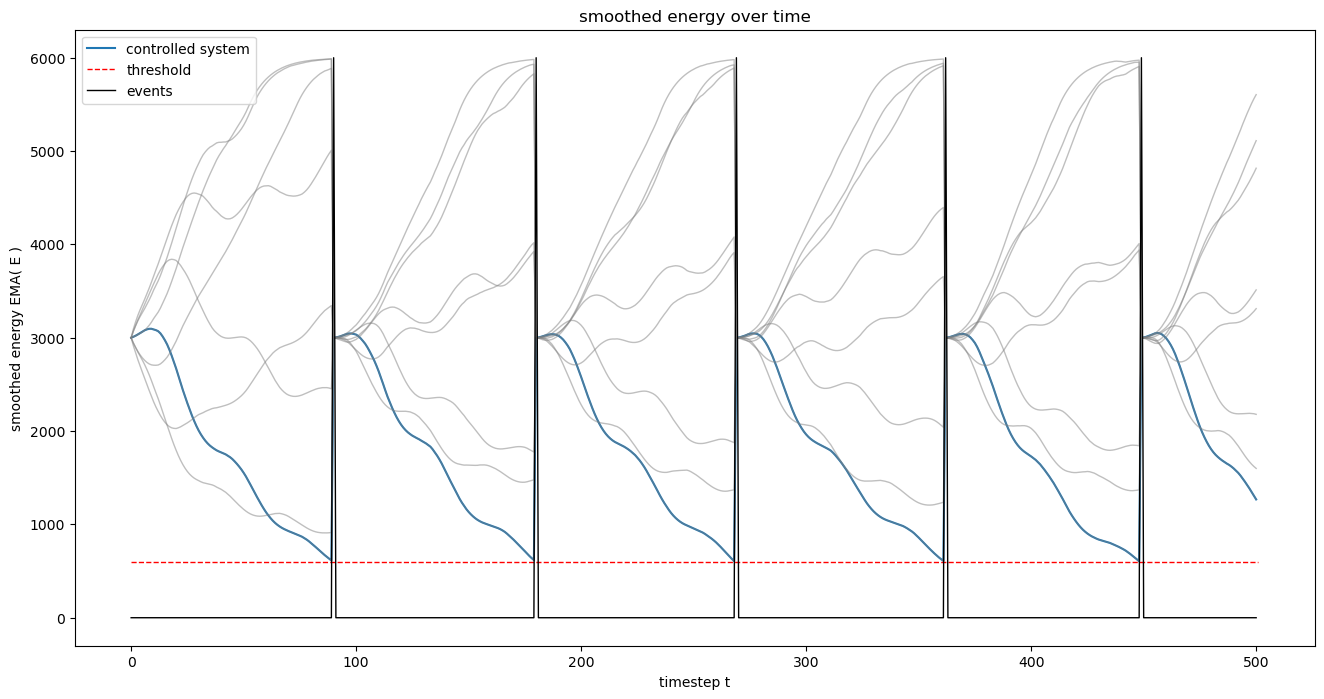

In [21]:
class App:
  # agent representing the app, a composition of other agents
  def __init__(self, 
               num_targets=8, 
               dt=0.1,
               energy_start=3e3, 
               trigger_conductivity=0.1,
               trigger_threshold=0.2):
    # config
    self.num_targets = num_targets
    self.energy_start = energy_start
    # trigger event once filtered energy falls below a threshold
    threshold = trigger_threshold * energy_start
    self.threshold = threshold
    self.targets = HarmonicOscillator(N=num_targets, dt=dt, energy_start=3e3, energy_max=6e3)
    self.trigger_in = FirstOrderLag(conductivity=trigger_conductivity, 
                                    s0=np.ones(num_targets) * energy_start)
    self.events = lambda x: x < self.threshold
    
  def copy(self):
    other = App()
    other.num_targets = self.num_targets
    other.energy_start = self.energy_start
    other.threshold = self.threshold
    other.targets = self.targets.copy()
    other.trigger_in = self.trigger_in.copy()
    other.events = lambda x: x < other.threshold
    return other
    
  def reset(self):
    targets = self.targets.reset()
    trigger_in = self.trigger_in.reset()
    events = self.events(trigger_in['x'])
    return {'targets': targets, 'events': events, 'latent': {'trigger_in': trigger_in}}
  
  def step(self, action):
    targets = self.targets.step(action['x'])
    trigger_in = self.trigger_in.step(targets['energy'])
    events = self.events(trigger_in['x'])
    # reset if necessary
    if events.sum() > 1e-6:
      targets = self.targets.reset()
      trigger_in = self.trigger_in.reset()
      
    self.s = {'targets': targets, 'events': events, 'latent': {'trigger_in': trigger_in}}
    return self.s

num_steps = 5_00
user_target = 0
  
app = App(num_targets=8)
user = UserA(target=user_target, conductivity=0.02, noise_scale=20.0)
system = Interaction(user=user, app=app)

# simulate closed-loop
os = [system.reset()]
for i in range(num_steps):
  os.append(system.step(os[-1]))

fig, ax = plt.subplots(figsize=(16, 8))
es_ema = [o['app']['latent']['trigger_in']['x'] for o in os]
plt.plot(np.array(es_ema)[:,user_target], label='controlled system')
plt.plot([0, len(os)], [app.threshold]*2, 'r--', linewidth=1., label='threshold')
plt.plot(es_ema, 'gray', alpha=0.5, linewidth=1.)
plt.plot(np.array([o['app']['events'].max() for o in os])*2*app.energy_start, 'k', linewidth=1, label='events');

plt.legend()
plt.xlabel('timestep t')
plt.ylabel('smoothed energy EMA( E )')
plt.title('smoothed energy over time')

### Sequential Target Generation

A user model for the full interaction requires a model of choosing the next target once the previous target has been selected.

#### `class TargetGenerator`

In [22]:
# User target generator
class TargetGenerator():
  
  def __init__(self, num_targets, rng):
    # config
    self.num_targets = num_targets
    self.rng = rng
    # state
    self.s = None
    self.s_one_hot = None
    
  def copy(self):
    other = TargetGenerator(num_targets=self.num_targets,
                           rng=self.rng)
    other.s = self.s
    other.s_one_hot = None if self.s_one_hot is None else self.s_one_hot.copy()
    return other
    
  def reset(self):
    self.assign(rng.choice(self.num_targets))
    return self.observation()
  
  def assign(self, target):
    self.s = target
    self.s_one_hot = np.eye(self.num_targets)[self.s]
  
  def step(self, trigger_out):
    # reset if true positive
    if trigger_out.sum() > 0 and trigger_out[self.s]:
      return self.reset()
    
    return self.observation()
  
  def observation(self):
    return {'s': self.s, 's_one_hot': self.s_one_hot}

#### `class User`

Text(0.5, 1.0, 'smoothed energy over time')

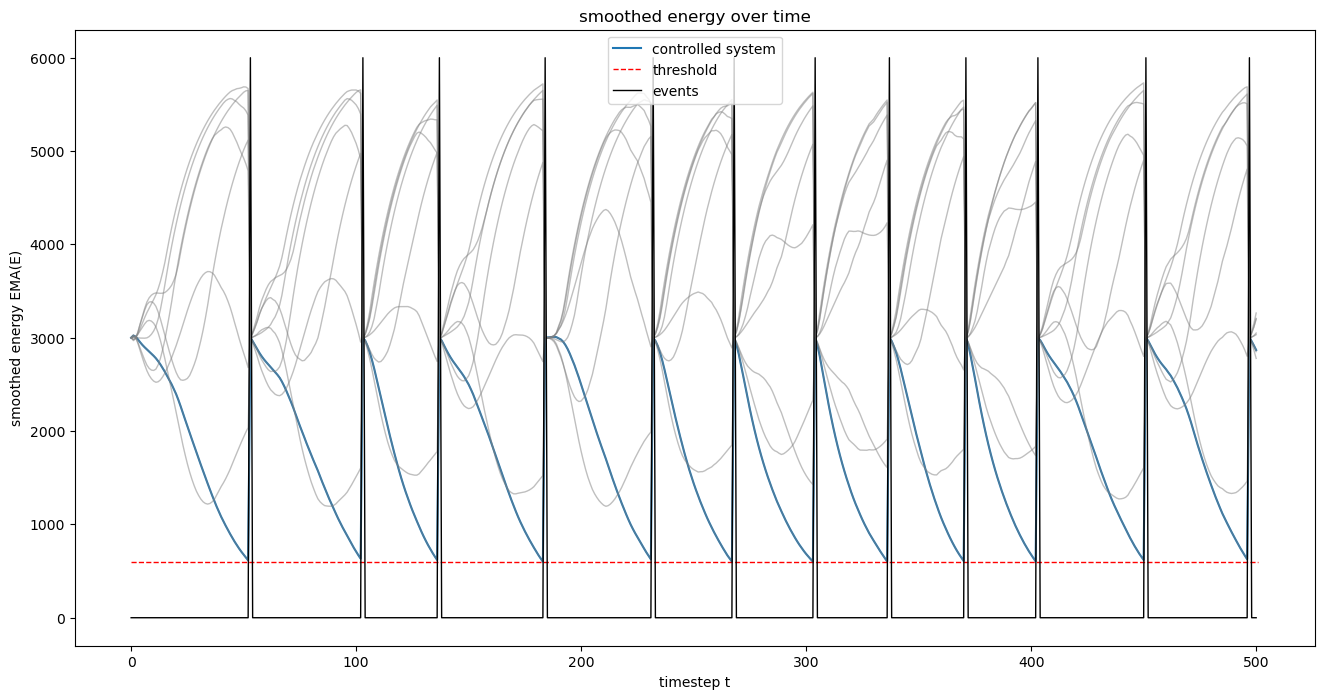

In [23]:
class User:
  # noisy lag of a specified target
  def __init__(self, num_targets=1, conductivity=0.2, bounds=None):
    self.target = TargetGenerator(rng=rng, num_targets=num_targets)
    self.lag = FirstOrderLag(conductivity=conductivity, s0 = np.zeros(1), bounds=bounds)
    self.noise = Gaussian(stdev=10., rng=rng)
    self.motor = NoisyLag(lag=self.lag, noise=self.noise)
    
  def copy(self):
    other = User()
    other.target = self.target.copy()
    other.lag = self.lag.copy()
    other.noise = self.noise.copy()
    other.motor = self.motor.copy()
    return other
    
  def reset(self):
    target = self.target.reset()
    output = self.motor.reset()
    output['latent'] = {'target': target}
    return output
  
  def step(self, app):
    target = self.target.step(app['events'])
    output = self.motor.step(app['targets']['x'][target['s']])
    output['latent'] = {'target': target}
    return output

# setup
num_steps = 5_00
app = App(num_targets=8, 
          trigger_threshold=0.2, 
          trigger_conductivity=0.06)
user = User(num_targets=app.num_targets)
system = Interaction(user=user, app=app)

# simulion
os = [system.reset()]
for i in range(num_steps):
  os.append(system.step(os[-1]))

# visualisation
fig, ax = plt.subplots(figsize=(16, 8))
targets = [o['app']['latent']['trigger_in']['x'][o['user']['latent']['target']['s']] for o in os]
plt.plot(targets, label='controlled system')
plt.plot([0, len(os)], [app.threshold]*2, 'r--', linewidth=1., label='threshold')
es_ema = [o['app']['latent']['trigger_in']['x'] for o in os]
plt.plot(es_ema, 'gray', alpha=0.5, linewidth=1.)
plt.plot(np.array([o['app']['events'].max() for o in os])*2*app.energy_start, 'k', linewidth=1, label='events');
plt.legend()
plt.xlabel('timestep t')
plt.ylabel('smoothed energy EMA(E)')
plt.title('smoothed energy over time')

## Evaluation

Now we have a complete system of a user generating sequences of intended targets and enacting movements consistent with controlling them, and an application that animates the movement of targets and triggers events associated with targets that appear to be controlled by the user.

### Performance Metrics

How well does this system perform?

To quantitatively evaluate the performance of this system, we measure _accuracy_ and _latency_ of the system under a nominal user, and _generalisation_ to varied user behavior.

- expected number of steps to trigger the intended target (latency)
- precision (true positives over true positives + false positives

#### `class Evaluation`

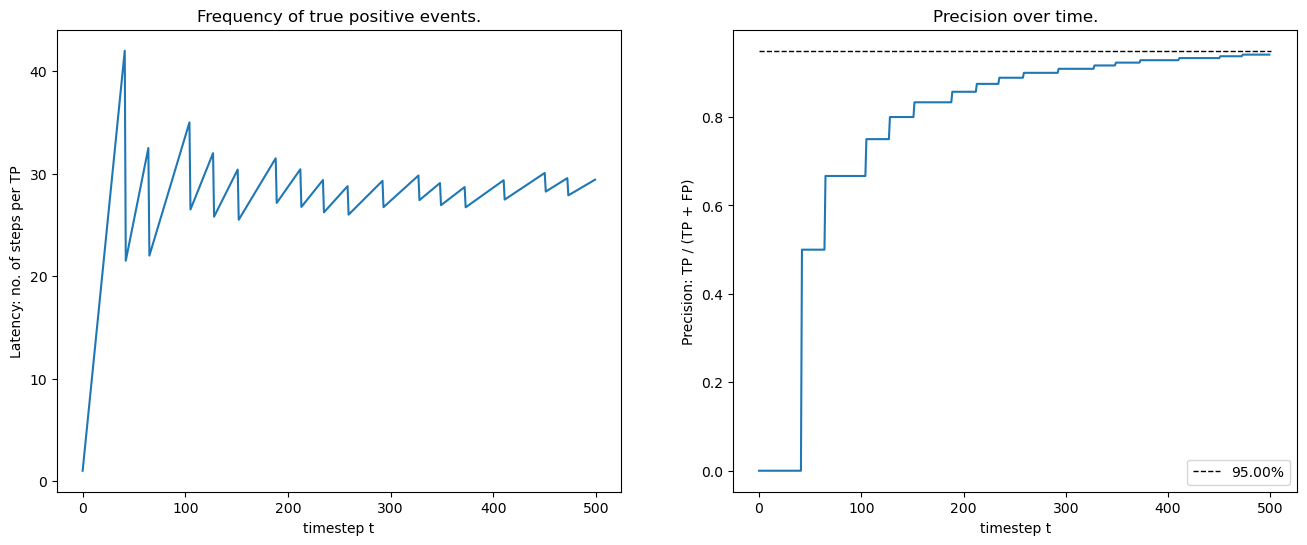

In [24]:
class Evaluation:
  """
  Evaluate performance either on the fly or post-hoc
  a. wrapping the system to be evaluated or
  b. calling an instance of this class with a list of pre-recorded states
  """
  def __init__(self, system=None):
    self.system = system
    # state
    self.num_steps = None # total number of environment steps
    self.num_tp = None # total number of true positive triggers
    self.num_fp = None # total number of false positive triggers
    
  def reset(self):
    self.num_steps = 0
    self.num_tp = 0
    self.num_fp = 0
    system = {} if self.system is None else self.system.reset()
    system['eval'] = self._observation()
    return system
  
  def _step(self, system, last_state):
    self.num_steps += 1
    if system['app']['events'].sum() > 1e-6:
      if system['app']['events'][last_state['user']['latent']['target']['s']] > 1e-6:
        self.num_tp += 1
      else:
        self.num_fp += 1
        
    system['eval'] = self._observation()
    return system
  
  def step(self, last_state):
    system = self.system.step(last_state)
    return self._step(system, last_state)
  
  def __call__(self, os):
    if len(os) < 1:
      return
    
    # apply evaluation post-hoc on sequence of observed interactions
    os[0]['eval'] = self.reset()
    for i in range(1, len(os)):
      os[i] = self._step(os[i], os[i-1])
      
  def _observation(self):
    return {
      'N': self.num_steps, 
      'TP': self.num_tp,
      'FP': self.num_fp}
      
  
# setup  
# double targets, halve conductivity and threshold
app = App(num_targets=8,
          trigger_conductivity=0.1,
          trigger_threshold=0.2)
user = User(num_targets=app.num_targets)
system = Interaction(user=user, app=app)

# alternative 1: wrap interaction in an evaluation
#system = Evaluation(system)

# simulation
os = [system.reset()]
for _ in range(5_00):
  os.append(system.step(os[-1]))
  
# post-hoc evaluation
Evaluation(None)(os)
  
# visualisation
def plot_latency(os, ax):
  plt.sca(ax)
  plt.title('Frequency of true positive events.')
  plt.xlabel('timestep t')
  plt.ylabel('Latency: no. of steps per TP')
  plt.plot([o['eval']['N']/(o['eval']['TP']+1) for o in os[1:]])
  
def plot_precision(os, ax, threshold=None):
  plt.sca(ax)
  plt.title('Precision over time.')
  plt.xlabel('timestep t')
  plt.ylabel('Precision: TP / (TP + FP)')
  plt.plot([o['eval']['TP']/(o['eval']['TP']+o['eval']['FP']+1) for o in os[1:]])
  if threshold is not None:
    plt.plot([0, len(os)], [threshold]*2, 'k--', linewidth=1., label=f'{100*threshold:.2f}%')
    plt.legend()
  
fig, ax = plt.subplots(1, 2, figsize=(2*8, 6))
plot_latency(os, ax[0])
plot_precision(os, ax[1], threshold=0.95)


### Useful Parameters

| dt | Targets | Lag | Thresh |
| --: | --: |  --: |  --: |
| 0.1 |   8 |  0.1 |  0.2 |
| 0.1 |  16 | 0.09 | 0.12 | 
| 0.1 |  32 | 0.07 | 0.07 |
| 0.1 |  64 | 0.04 | 0.04 |
| 0.1 | 128 | 0.01 | 0.02 |

# Active Inference

## Bayesian Inference of Intent

This section runs the Bayesian belief update of an active inference agent on an observed simulation of interaction and visualises the belief over targets.

The User Model's role in active inference is to provide a probabilistic approximation of the generative process: how the user acts as a function of the user's internal state; and how the user's internal state changes over time.

For that we define a likelihood-based generative model of user input. Here, we use a model that is similar to the generative process (Simulated User) with some small differences and one free parameter that needs to be inferred from observations of interaction. The user model perceives the oscillator positions exactly, acts to track with some delay represented as a first-order lag with parameter $\lambda_{model}$ and with motor imprecision represented as Gaussian white noise on the lagging positions.

$x_{model} = \text{lag}(x_{gui}^{t}, x_{usr}^{t-1};\lambda_{model})+ \mathcal{N}(0;\sigma_{model}^2) \approx x_{usr} = \text{lag}( \mathcal{N}(x_{gui};\sigma_{usr}^2), x_{usr}^{t-1}; \lambda_{usr} )$

While we keep the model very close to the simulated user apart from it not having access to the intended target, 
itt does not match exactly and the lag parameter $\lambda_{model}$ is unknown a priori.

#### `class UserModel`

In [26]:
from scipy.stats import norm

class UserModel:
  
  def __init__(self, 
               num_targets, # how many targets are there?
               conductivity, # what is my assumption about the user lag
               stdev, # what is my noise assumption over target tracking precision?):
               bounds, # what is the user's operating range
               p_fp=0.05, # chance of false positive event
               p_fn=0.01, # chance of false negative, i.e. user switched target without an event firing
              ):
    # config
    self.num_targets = num_targets
    self.k = conductivity
    self.stdev = stdev
    self.bounds = bounds
    self.p_fp = p_fp
    self.p_fn = p_fn
    
  def copy(self):
    # no need to copy because the model is stateless
    print('Returning self, because we assume UserModel is stateless.')
    return self
  
  def get_probabilities(self, action):
    user_action = action['user']
    user_now = user_action['x'] # user action (observable)
    user_prev = user_now - user_action['dx'] # previous state of the user's end-effector
    ui_state = action['app']['targets']['x'] # application state
    has_triggered = action['app']['events'].sum() > 0 # application state (continued)
    
    # simple user model: 
    # - expected user_x is previous user_x lagging ui with assumed conductivity
    # - consider user operating range is bounded -> bound target position
    # - assume some Gaussian density around clipped expected user_x
    expected_user_x = np.outer(1-self.k, user_prev) + np.outer(self.k, ui_state)
    if self.bounds is not None:
      expected_user_x = np.clip(expected_user_x, self.bounds[0], self.bounds[1])
    p_o_given_s = norm.pdf(user_now, loc=expected_user_x, scale=self.stdev)
    
    # - user is likely to switch goals when an event occured
    p_switch = has_triggered*(1-self.p_fp) + (1-has_triggered) * self.p_fn
    return {'p_o_given_s': p_o_given_s, 'p_switch': p_switch}
  
  def sample_action(self, o, conductivity):
    user_last = o['user']['x']
    ui_state = o['app']['targets']['x']
    i = o['user']['target']['s']
    k = conductivity
    # mean output
    expected_user_x = (1-k)*user_last + k*ui_state[i]
    expected_user_x = np.clip(expected_user_x, self.bounds[0], self.bounds[1])
    # sample from selected state's emission probability
    user_next = norm.rvs(loc=expected_user_x, scale=self.stdev, size=1, random_state=None)
    return {'x': user_next, 'dx': user_next - user_last}


### Passive Bayesian Observer

In [27]:
# Continuous observation active inference agent
# a. Belief Update agent

class BayesianObserver:
  
  def __init__(self, model, q0_target, q0_conductivity, rng):
    """
    Args:
      model: model of the interaction between a user and an application
      q0_target: initial belief distribution over user targets
      q0_conductivity: initial belief distribution over the user lag parameter
    """
    
    # config
    self.model = model
    self.q0_target = q0_target
    self.q0_conductivity = q0_conductivity
    self.rng = rng
    
    # state
    self.q = None
    
  def copy(self):
    other = BayesianObserver(model=self.model,
              q0_target=self.q0_target,
              q0_conductivity=self.q0_conductivity,
              rng=rng)
    
    other.q = self.q.copy()
    return other
  
  def reset(self):
    # model is assumed to be stateless self.model.reset()
    # initialise believe as the outer product of beliefs over individual state dimensions
    self.q = np.outer(self.q0_conductivity, self.q0_target)
    # return marginal distributions over individual state dimensions
    return {'target': self.q.sum(axis=0), 'conductivity': self.q.sum(axis=1), 'q': self.q}
            
  def step(self, action):
    # update user model to synchronise with observation
    o = self.model.get_probabilities(action)
    p_switch = o['p_switch'] # probability of the user to have switched target
    p_o_given_s = o['p_o_given_s']
    
    # update belief through time
    # - there is some chance that the user has switched their target
    # - in this case, the new target is assumed to be distributed as per q0_target
    # - in this case, user conductivity is assumed to remain unchanged
    q_marginal_conductivity = self.q.sum(axis=1)
    q_switch = np.outer(q_marginal_conductivity, self.q0_target)
    self.q = p_switch*q_switch + (1-p_switch)*self.q
    
    # update belief based on new observation
    self.q = self._update_belief(p_o_given_s)
    return {'target': self._marginal_target(), 
            'conductivity': self._marginal_conductivity(), 
            'q': self.q}
  
  def sample(self):
    k_index = self.rng.choice(self.q.shape[0], p=self._marginal_conductivity())
    i = self.rng.choice(self.q.shape[1], p=self._conditional_target(k_index))
    p = self.joint_probability(target=i, conductivity_index=k_index)
    return {'target': i, 
            'conductivity_index': k_index,
            'conductivity': self.model.k[k_index], 
            'p': p}
    
  def joint_probability(self, target, conductivity_index):
    return self.q[conductivity_index, target]

  def _marginal_target(self):
    return self.q.sum(axis=0)
  
  def _conditional_target(self, k_index):
    return self.q[k_index]/self.q[k_index].sum()
  
  def _marginal_conductivity(self):
    return self.q.sum(axis=1)
    
  def _update_belief(self, p_o_given_s):
    joint = p_o_given_s * self.q
    return joint / joint.sum()

### Simulation

It appears important for the user model to have less noise than the true system in order to identify the true parameterisation of the system, i.e. identify the user lag and user intent.

In [31]:
class ObservedInteraction:
  
  def __init__(self, app, user):
    self.system = Interaction(user=user, app=app)
    
    num_targets = app.num_targets
    # discretised user lag
    num_k =10
    self.k = np.linspace(0.05, 0.5, num_k)
    # use distribution over conductivity and true user noise
    self.model =  UserModel(num_targets=num_targets, 
                            conductivity=self.k,
                            stdev=user.noise.stdev*0.5, 
                            bounds=user.lag.bounds, p_fp=0.01, p_fn=0.01)
    # Bayesian inference with uniform prior over targets 
    q0_target = np.ones(num_targets)/num_targets
    q0_k = np.ones(num_k)/num_k
    self.observer = BayesianObserver(model=self.model, 
                                     q0_target=q0_target, 
                                     q0_conductivity=q0_k, 
                                     rng=rng)
    
  def reset(self):
    o = self.system.reset()
    o['observer'] = self.observer.reset()
    return o
    
  def step(self, last_state):
    o = self.system.step(last_state)
    o['observer'] = self.observer.step(o)
    return o

app = App(num_targets=32, 
          trigger_conductivity=0.07,
          trigger_threshold=0.07)
user = User(num_targets=app.num_targets, conductivity=0.25)
system = ObservedInteraction(app=app, user=user)

os = [system.reset()]
for _ in range(1_000):
  os.append(system.step(os[-1]))

Text(0.5, 1.0, 'smoothed energy over time')

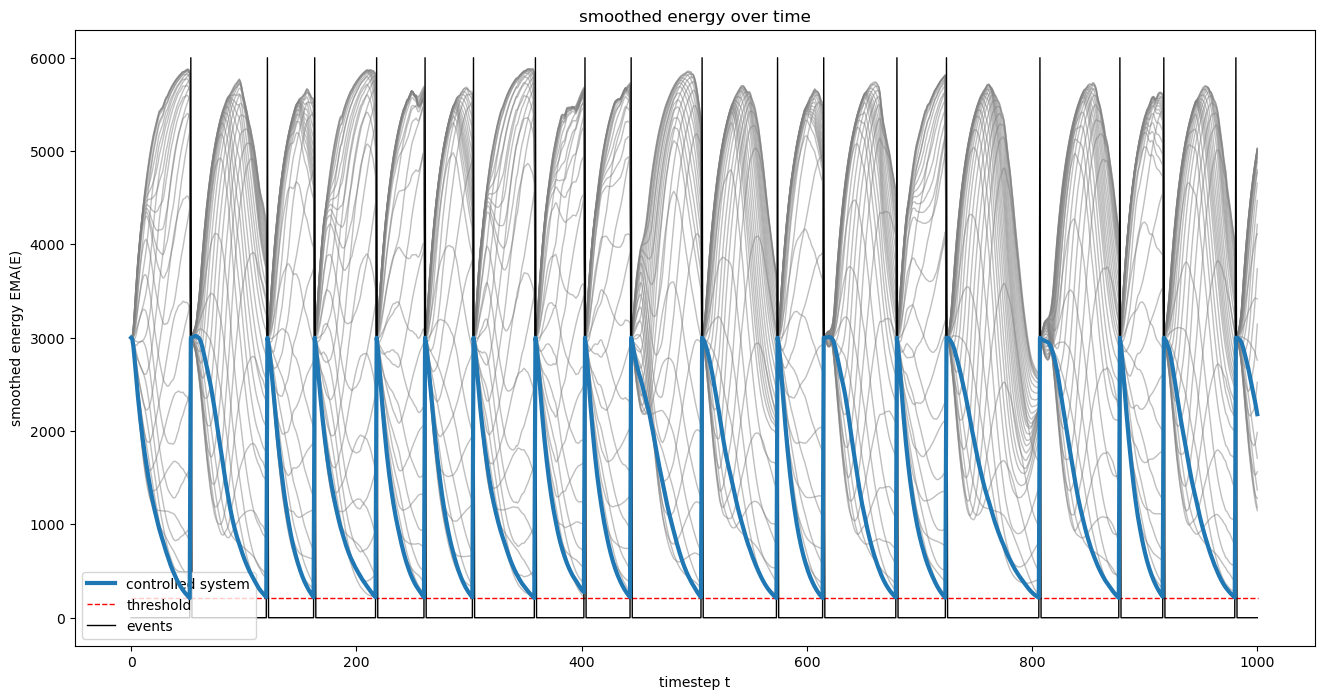

In [32]:
# visualisation
fig, ax = plt.subplots(figsize=(16, 8))
targets = [o['app']['latent']['trigger_in']['x'][o['user']['latent']['target']['s']] for o in os]
plt.plot(targets, label='controlled system', zorder=100, linewidth=3.)
plt.plot([0, len(os)], [app.threshold]*2, 'r--', linewidth=1., label='threshold')
es_ema = [o['app']['latent']['trigger_in']['x'] for o in os]
plt.plot(es_ema, 'gray', alpha=0.5, linewidth=1.)
plt.plot(np.array([o['app']['events'].max() for o in os])*2*app.energy_start, 'k', linewidth=1, label='events');
plt.legend()
plt.xlabel('timestep t')
plt.ylabel('smoothed energy EMA(E)')
plt.title('smoothed energy over time')

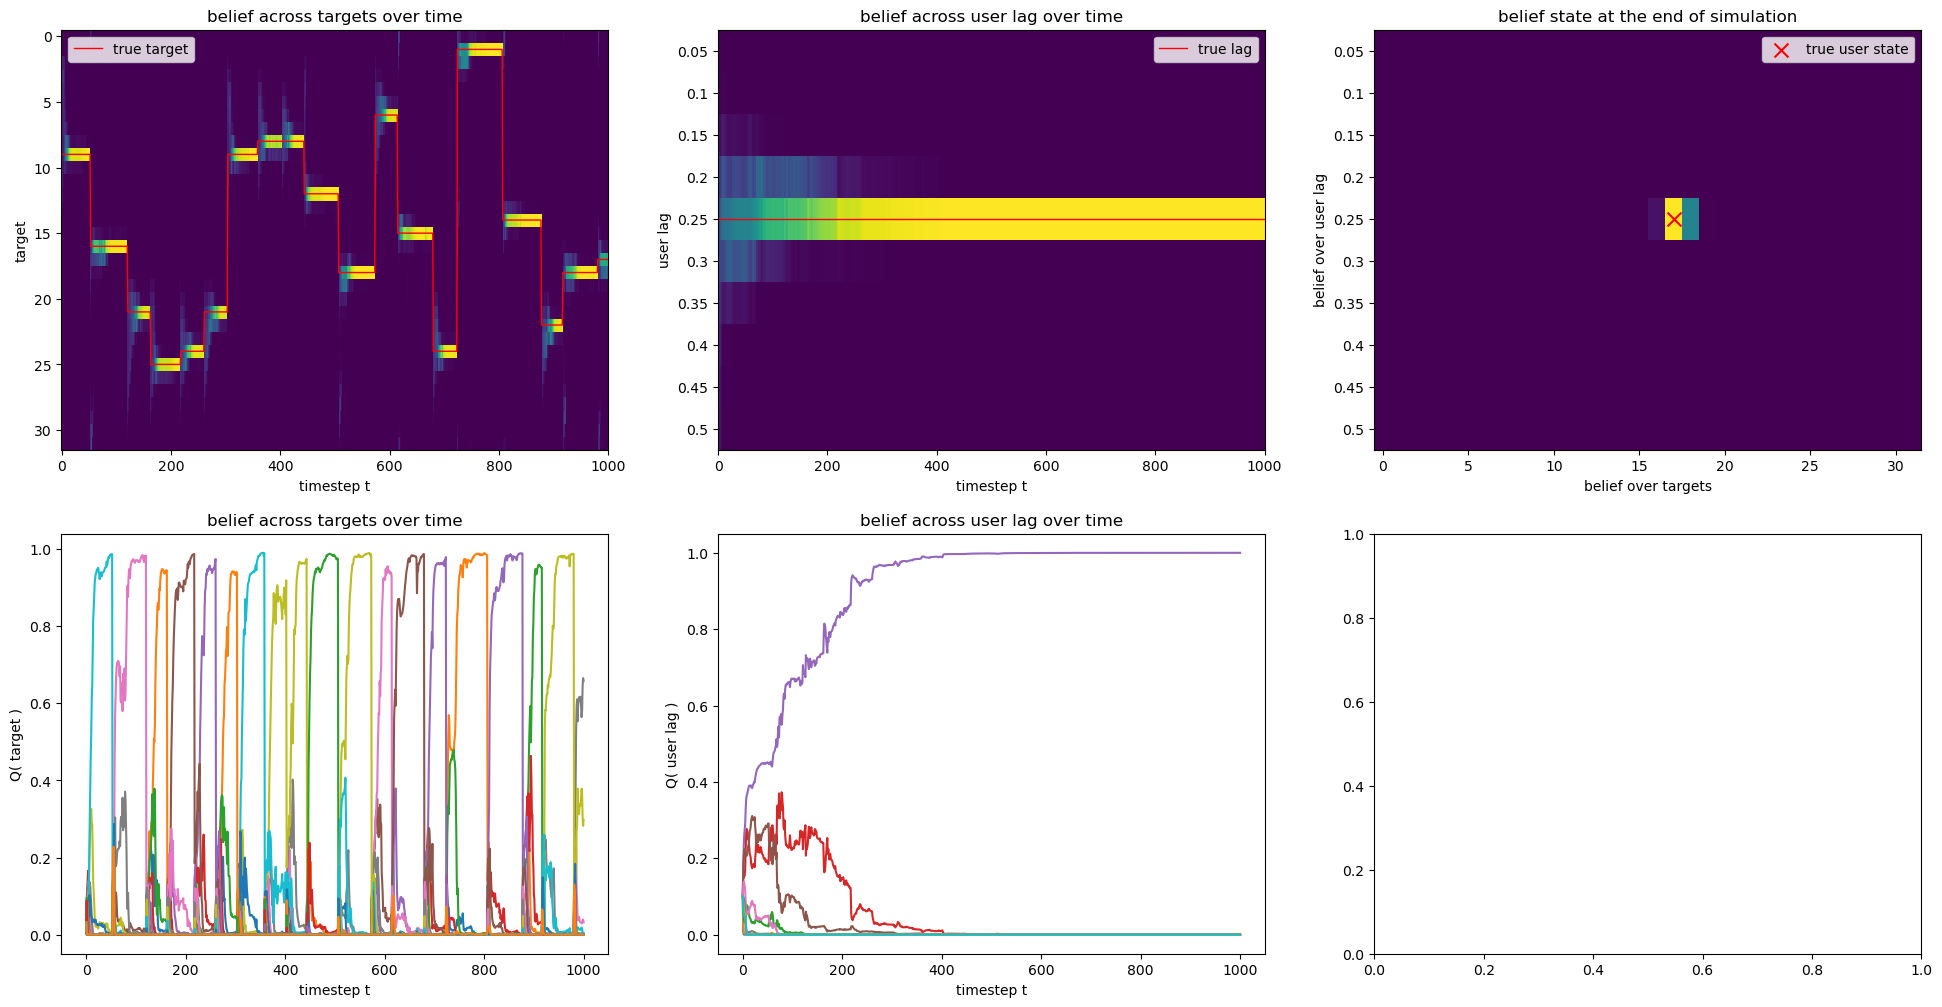

In [33]:
# plot belief
os_view = os
user_k = system.system.user.lag.k
true_user_conductivity = np.argmin(np.abs(user_k - system.k))

fig, axes = plt.subplots(2, 3, figsize=(3*8, 2*6))

# belief about targets over time
plt.sca(axes[0][0])
plt.title('belief across targets over time')
plt.xlabel('timestep t')
plt.ylabel('target')
qs = [o['observer']['target'] for o in os_view]
plt.imshow(np.array(qs).T, aspect='auto', interpolation='none')
plt.plot([o['user']['latent']['target']['s'] for o in os_view], 'r', linewidth=1., label='true target')
plt.legend()

plt.sca(axes[1][0])
plt.title('belief across targets over time')
plt.xlabel('timestep t')
plt.ylabel('Q( target )')
qs = [o['observer']['target'] for o in os_view]
plt.plot(qs)
#plt.plot([o['user']['latent']['target']['s'] for o in os_view], 'r', linewidth=1., label='true target')

# belief about conductivity over time
plt.sca(axes[0][1])
plt.title('belief across user lag over time')
plt.xlabel('timestep t')
plt.ylabel('user lag')
plt.yticks(np.arange(system.k.shape[0]), [f"{k:.2}" for k in system.k])
qs = [o['observer']['conductivity'] for o in os_view]
plt.imshow(np.array(qs).T, aspect='auto', interpolation='none')
plt.plot([0, len(qs)-1], [true_user_conductivity]*2, 'r', linewidth=1., label='true lag')
plt.legend()

plt.sca(axes[1][1])
plt.title('belief across user lag over time')
plt.xlabel('timestep t')
plt.ylabel('Q( user lag )')
qs = [o['observer']['conductivity'] for o in os_view]
plt.plot(qs)

# joint instantaneous belief
final_target = os_view[-1]['user']['latent']['target']['s']
plt.sca(axes[0][2])
plt.imshow(system.observer.q, aspect='auto', interpolation='none')
plt.scatter(final_target, true_user_conductivity, marker='x', color='red', s=10**2, label='true user state')
plt.yticks(np.arange(system.k.shape[0]), [f"{k:.2}" for k in system.k])
plt.xlabel('belief over targets')
plt.ylabel('belief over user lag')
plt.title('belief state at the end of simulation')
plt.legend()

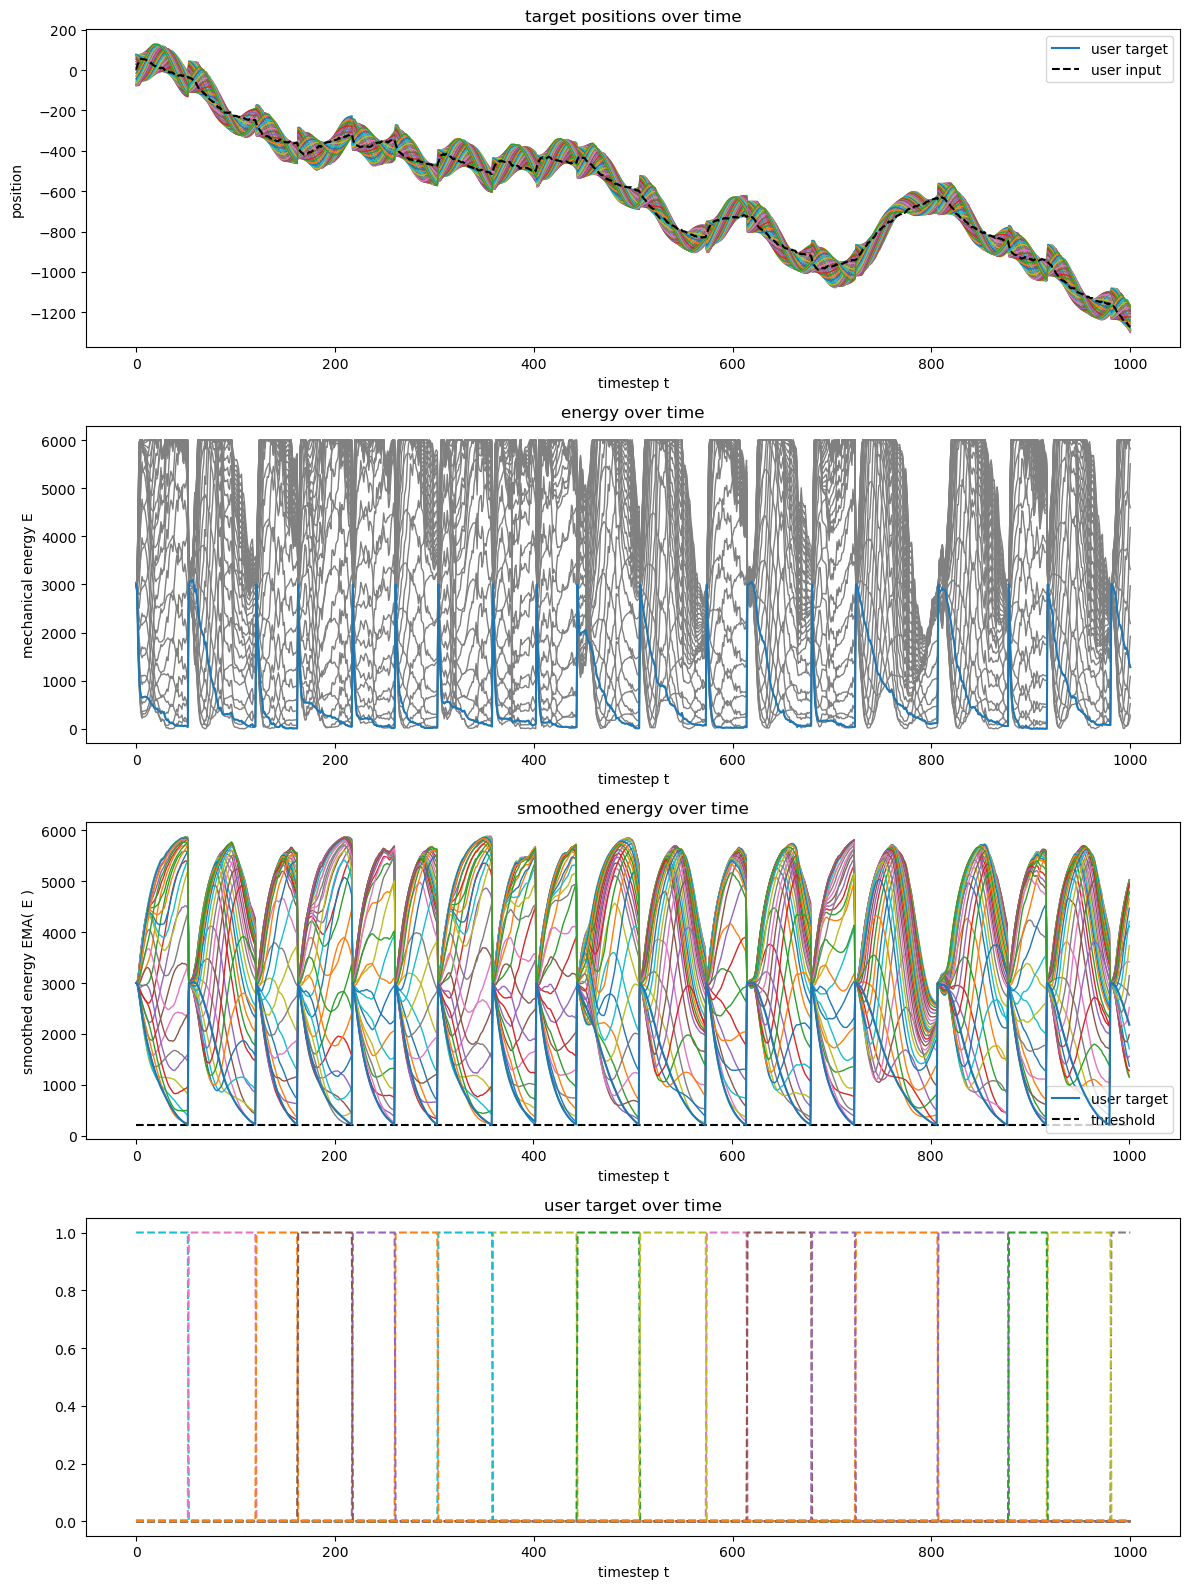

In [34]:
# plot dynamics
os = os

def plot_positions(os, ax, alpha=1., format='gray'):
  # target positions over time
  plt.sca(ax)
  plt.title('target positions over time')
  xs = np.array([o['app']['targets']['x'] for o in os])
  ts = np.array([o['user']['latent']['target']['s'] for o in os])
  plt.plot(xs[np.arange(ts.shape[0]),ts], label='user target')
  plt.plot(xs, format, alpha=alpha, linewidth=1.)
  plt.xlabel('timestep t')
  plt.ylabel('position')  
  # user input over time
  y = np.array([o['user']['x'] for o in os])
  plt.plot(y, 'k--', label='user input')
  plt.legend()

def plot_velicities(os, ax):
  # target velocity over time
  plt.sca(ax)
  plt.title('target velocities over time')
  vs = np.array([o['app']['targets']['v'] for o in os])
  ts = np.array([o['user']['latent']['target']['s'] for o in os])
  plt.plot(vs[np.arange(ts.shape[0]),ts], label='user target')
  plt.plot(vs)
  plt.xlabel('timestep t')
  plt.ylabel('velocity')

def plot_mass(os, ax):
  # target mass over time
  plt.sca(ax)
  plt.title('mass over time')
  ms = np.array([o['app']['targets']['latent']['mass'] for o in os])
  plt.plot(ms)
  plt.plot(ms[np.arange(num_steps+1),ts], 'k-', label='user target')
  plt.xlabel('timestep  t')
  plt.ylabel('mass')

def plot_spring(os, ax):
  # target spring coefficient
  plt.sca(ax)
  plt.title('spring coefficient over time')
  ss = np.array([o['app']['targets']['latent']['spring'] for o in os])
  plt.plot(ss)
  plt.plot(ss[np.arange(num_steps+1),ts], 'k-', label='user target')
  plt.xlabel('timestep t')
  plt.ylabel('spring coefficient')

def plot_energies(os, ax, alpha=1., format='gray'):
  # target energies
  plt.sca(ax)
  plt.title('energy over time')
  es = np.array([o['app']['targets']['energy'] for o in os])
  ts = np.array([o['user']['latent']['target']['s'] for o in os])
  plt.plot(es[np.arange(ts.shape[0]),ts], label='user target', zorder=100)
  plt.plot(es, format, alpha=alpha, linewidth=1.)
  #plt.imshow(es.T, aspect='auto')
  plt.xlabel('timestep t')
  plt.ylabel('mechanical energy E')
  
def plot_trigger_input(os, ax, alpha=1., format='gray'):  
  # trigger input over time
  plt.sca(ax)
  y = np.array([o['app']['latent']['trigger_in']['x'] for o in os])
  ts = np.array([o['user']['latent']['target']['s'] for o in os])
  plt.plot(y[np.arange(ts.shape[0]),ts], label='user target', zorder=100)
  plt.plot(y, format, alpha=alpha, linewidth=1.)
  plt.plot([0, len(os)], [app.threshold]*2, 'k--', label='threshold')
  #plt.imshow(y.T, aspect='auto')
  plt.legend()
  plt.xlabel('timestep t')
  plt.ylabel('smoothed energy EMA( E )')
  plt.title('smoothed energy over time')
  
def plot_trigger_output(os, ax):
  # trigger output over time
  y = np.array([o['app']['events'] for o in os])
  plt.sca(axes[7])
  plt.plot(y)
  plt.xlabel('timestep t')
  plt.ylabel('trigger output')
  plt.title('events triggered over time')
  
def plot_user_target(os, ax):
  # user target
  plt.sca(ax)
  plt.title('user target over time')
  ts = np.array([o['user']['latent']['target']['s_one_hot'] for o in os])
  plt.plot(ts, '--')
  plt.xlabel('timestep t')
  
def plot_belief(os, ax, varname='target'):
  # plot belief
  plt.sca(ax)
  plt.title('Observer belief over time')
  qs = [o['belief'][varname] for o in os]
  plt.imshow(np.array(qs).T, aspect='auto')
  plt.plot([o['user_target']['s'] for o in os], 'r')
  plt.xlabel('timestep t')
  plt.ylabel('target id')
  
def plot_max_belief(os, ax, varname='target'):
  plt.sca(ax)
  plt.title('Observer max. belief over time')
  qs = np.array([o['belief'][varname] for o in os])
  plt.plot(qs.max(axis=1))

num_plots = 4
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 4*num_plots))

plot_positions(os, axes[0], format='')
#plot_velocities(os, axes[1])
#plot_mass(os, axes[2])
#plot_spring(os, axes[3])
plot_energies(os, axes[1])
plot_trigger_input(os, axes[2], format='')
plot_user_target(os, axes[3])
#plot_trigger_output(os, axes[7])
#plot_belief(os, axes[2])
#plot_max_belief(os, axes[2])

plt.tight_layout()

### Environment State

| | | | dim | |
|:-- |:-- |:--| --: | :-- |
|App | targets | masses | N | 
| | | spring constants | N |
| | | damping coefficients | N |
| | | positions | N |
| | | velocities | N |
| | | anchor position | 1 |
| | trigger_in | conductivity | 1 |
| | | smoothed energies | N |
| | events | threshold | 1 |
| | | trigger status | N |
| User | target | index | 1 | unobserved; **to be inferred**
| | noise | scale | 1 | unobserved; treated as hyperparameter
| | lag | conductivity | 1 | unobserved; **to be inferred**
| | | target positions | N | unobserved; estimated from action 
| | motor | mouse position | 1 | observed
|---|---|---|**8N+7** |



## Intervention

### Optimal Intervention

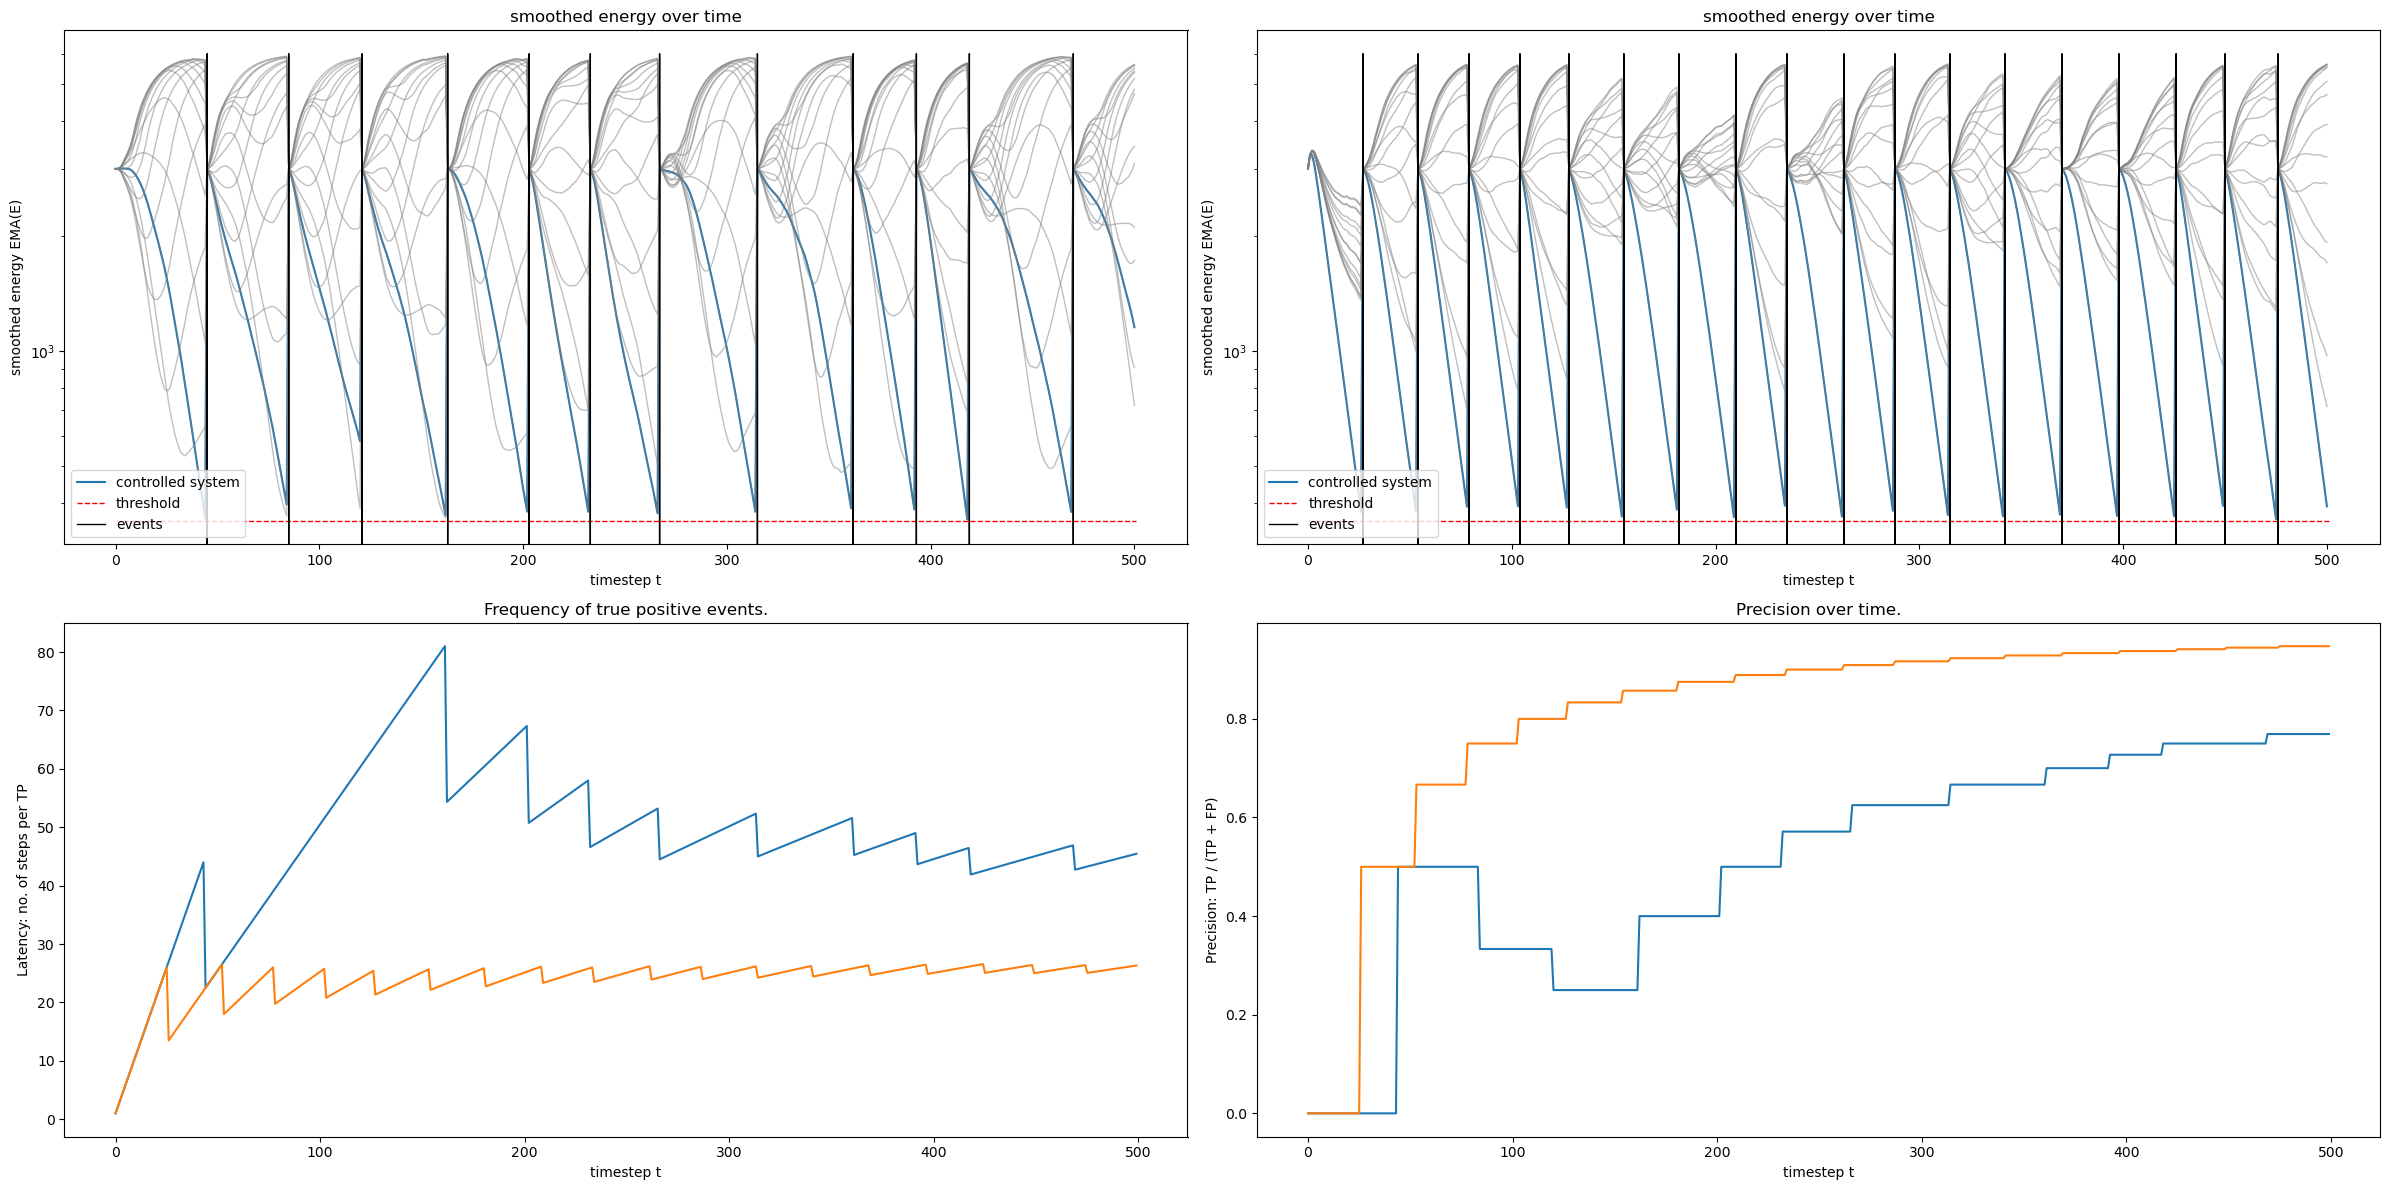

In [35]:
# let's start with a setup where we synthetically intervene such that, in every timestep, the user's target energy is reduced
# this gives a baseline performance estimate of what could be achieved in the presence of perfect knowledge

# setup
num_steps = 5_00
app = App(num_targets=16,
          trigger_threshold=0.12, 
          trigger_conductivity=0.09)
user = User(num_targets=app.num_targets)
system = Interaction(user=user, app=app)

# simulation without intervention
os = [system.reset()]
for i in range(num_steps):
  os.append(system.step(os[-1]))
  
# simulation with intervention
os_with = [system.reset()]
for i in range(num_steps):
  e = app.targets.energy()
  e_new = e * (1 + user.target.s_one_hot * -0.2)
  e_new = e_new / e_new.sum() * e.sum()
  app.targets.set_energy(e_new)
  os_with.append(system.step(os_with[-1]))
  
# evaluate both
eval = Evaluation()
eval(os)
eval(os_with)

# visualisation
def plot_selection(os, ax):
  plt.sca(ax)
  targets = [o['app']['latent']['trigger_in']['x'][o['user']['latent']['target']['s']] for o in os]
  plt.semilogy(targets, label='controlled system')
  plt.plot([0, len(os)], [app.threshold]*2, 'r--', linewidth=1., label='threshold')
  es_ema = [o['app']['latent']['trigger_in']['x'] for o in os]
  plt.plot(es_ema, 'gray', alpha=0.5, linewidth=1.)
  plt.plot(np.array([o['app']['events'].max() for o in os])*2*app.energy_start, 'k', linewidth=1, label='events');
  plt.legend()
  plt.xlabel('timestep t')
  plt.ylabel('smoothed energy EMA(E)')
  plt.title('smoothed energy over time')

fig, ax = plt.subplots(2, 2, figsize=(2*12, 2*6))
plot_selection(os, ax[0][0])
plot_selection(os_with, ax[0][1])

plot_latency(os, ax[1][0])
plot_precision(os, ax[1][1])
plot_latency(os_with, ax[1][0])
plot_precision(os_with, ax[1][1])
plt.tight_layout()

### Evaluating Alternatives

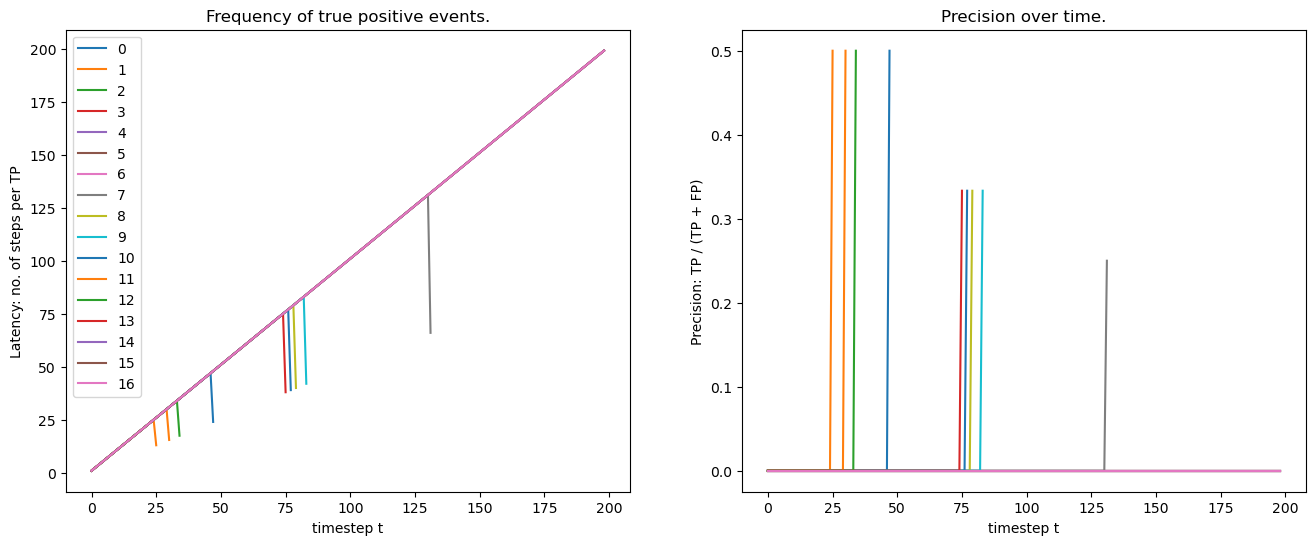

In [38]:
# we need to be able to set the user target
user_target = 0
time_horizon = 200

app = App(num_targets=16,
          trigger_threshold=0.12, 
          trigger_conductivity=0.09)
user = User(num_targets=app.num_targets)
system = Interaction(user=user, app=app)


# define set of actions (plans are repeated application of the same action
num_targets = app.num_targets
attenuation = 0.2 # how much to reduce energy of specified target
a = np.ones((num_targets+1, num_targets)) 
a[1:,:] -= attenuation * np.eye(num_targets)
a = a/a.sum(axis=1, keepdims=True) * num_targets

# init canvas
fig, ax = plt.subplots(1, 2, figsize=(2*8, 6))

# create plans from repeated actions
plans = np.tile(a[:,None], (1,time_horizon,1))
nefes = []

for plan in plans:
  # intialise with user target
  os = [system.reset()]
  user.target.assign(user_target)

  # forward simulation
  for i in range(time_horizon):
    # intervention
    app.targets.set_energy(plan[i] * app.targets.energy())
    # simulation
    os.append(system.step(os[-1]))
    # stop early once an event was triggered
    if os[-1]['app']['events'][user_target] > 1e-6:
      break

  # pragmatic value estimate
  # todo: vectorize
  pragmatic = []
  # for each timestep, identify whether no event, the wrong event or the target event was triggered  
  for o in os:
    if o['app']['events'].sum() > 1e-6:
      if o['app']['events'][user_target] > 1e-6:
        pragmatic.append(log_p_c[1])
      else:
        pragmatic.append(log_p_c[2])
    else:
      pragmatic.append(log_p_c[0])

  nefes.append(np.mean(pragmatic)) # average across rollouts

  os = os[1:]
  Evaluation(None)(os)
  plot_latency(os, ax[0])
  plot_precision(os, ax[1])
  
ax[0].legend([f'{i}' for i in range(plans.shape[0])])

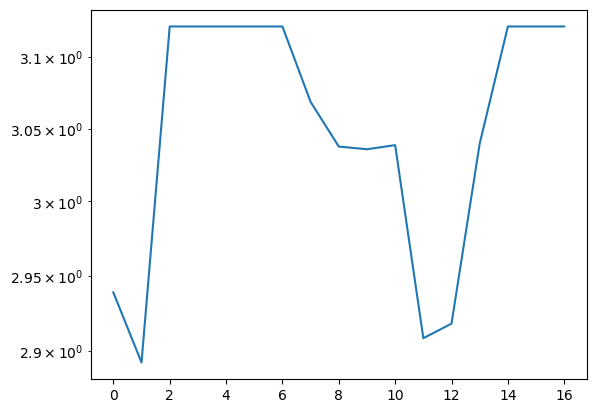

In [39]:
plt.semilogy(-np.asarray(nefes))

In [37]:
# now we formalise how to identify this opportunity (by rolling out hypothetical futures under different plans)

# setup
app = App(num_targets=16,
          trigger_threshold=0.12, 
          trigger_conductivity=0.09)
user = User(num_targets=app.num_targets)
system = Interaction(user=user, app=app)

# define pragmatic value
p_c = [0.05-1e-4, # triggered nothing
       0.95, # triggered intended target
       1e-4] # triggered the wrong target
log_p_c = np.log(p_c)
print('p(o|C)', p_c)

# define set of actions (plans are repeated application of the same action
num_targets = 3
attenuation = 0.4 # how much to reduce energy of specified target
a = np.ones((num_targets+1, num_targets)) 
a[1:,:] -= attenuation * np.eye(num_targets)
a = a/a.sum(axis=1, keepdims=True) * num_targets
print('actions', a)

# create plans from repeated actions
time_horizon = 5
plans = np.tile(a[:,None], (1,time_horizon,1))

nefes = []
for plan in plans:
  
  # simulation without intervention
  os = [system.reset()]
  for i in range(num_steps):
    os.append(system.step(os[-1]))

# for debugging, use true user state in rollouts


p(o|C) [0.0499, 0.95, 0.0001]
actions [[1.         1.         1.        ]
 [0.69230769 1.15384615 1.15384615]
 [1.15384615 0.69230769 1.15384615]
 [1.15384615 1.15384615 0.69230769]]


## Acting to increase pragmatic value

We show how action can help to gain information about user intent and to increase the probability of observing preferred state by intervening on the mediating mechanism instead of the decision rule itself. This is in contrast to previous work such as BIGNav, which used Bayesin information gain directly for control by triggering events compatible with current belief directly. We argue that the proposed approach is more generalisable as it requires only access to the communication layer as opposed to the controlled software. It can also enable adapting faster to parameters of the user that are consistent across applications, such as touch offsets, by learning from their interaction with multiple applications.

In active inference, sequences of actions (plans) are scored by the negative expected free energy, and selected by exponentiating and normalizing, i.e. sampling from the softmax over plans. Plans $\pi: a_0, a_1, ..., a_{K-1}$ define sequences of actions up to a finite horizon of $K$ timesteps into the future. The expected free energy can be decomposed in various ways and here we chose one that we find most intuitive, involving a _pragmatic_ term and an _information gain_ term. 

The _pragmatic_ term assesses the probability of arriving in states following $\pi$ that the agent desires, or of encountering observations that the agent desires. In this context, $Q_\theta$ is estimated by propagating beliefs through the environment transition dynamics following the sequence of actions defined by $\pi$, and observations are halucinated by sampling from the emission probability distributions.

$\mathbb{E}_{s \sim Q_{\theta}}\left[\log p_c(s)\right] \quad \text{or} \quad \mathbb{E}_{s \sim Q_{\theta}, o \sim p(o|s)}\left[\log p_c(o)\right]$

The _information gain_ term quantifies the belief update due to making observations in future states.

$\mathbb{E}_{s \sim Q_{\theta}, o \sim p(o|s)}\left[ D_{KL}(\, Q_{\theta'}(s|o),  Q_{\theta}(s) \,) \right]$


We consider actions to represent interventions on individual masses of the oscillating mechanism associated with different targets. An increase in mass increases kinetic energy and decreases the oscillation frequency, whereas a decrease in mass decreases kinetic energy and increases the oscillation frequency, respectively. A discrete action space is defined over $2N+1$ actions corresponding to no intervention, increasing, or decreasing the mass of $N$ individual targets by a fixed proportion ($\pm10\%$).

The preferences over states and observations of an adaptive user interface could be informed by a variety of factors including the users' intent, e.g., preferring observations that are compatible with the application behaving as the user intends), the risk associated with different application states, e.g., preferring observations that are incompatible with the application being driven into unsafe states, and a policy to nudge users into preferable application states, e.g., to expose users to new features or to increase their chance of picking more healthy, more economical, or more environmentally friendly options. Because most of these factors assume some domain knowledge of the application to be meaningful, we focus here on the first, i.e. preferring observations that are compatible with user intention.

### Option A: preference over trigger events

Here, we define the preference distribution over observations as a function of our belief about the user's intended target and observed trigger events. Action selection thereby attempts to drive the dynamic system into a configuration that makes it easier for the user to decrease their intended target's energy, harder for the user to accidentally decrease any other target's energy, and potentially assists with energy reduction directly.

One drawback of this approach is that hypothetical trigger events are sparse and we therefore need long rollouts to identify an effect

### Option B: preference over energy vectors



In [ ]:
# create intervention vectors
num_targets = 3
attenuation = 0.4
a = np.ones((num_targets+1, num_targets)) 
a[:num_targets,:] -= attenuation * np.eye(num_targets)
a = a/a.sum(axis=1, keepdims=True) * num_targets
a

In [ ]:
# generate a set of plans, each doing nothing after the first timestep
#first_action = np.arange(num_actions)[:,None]
#remaining_actions = np.ones((num_actions, time_horizon-1)) * (num_actions - 1)
#plans = np.hstack( [first_action, remaining_actions] ).astype(int)

# - test concept with plan of always taking no action
nefes = []
for plan in plans:
  #print(plan)
  total_steps = 0
  pragmatic = 0
  
  for _ in range(num_rollouts):
    # - sample user state from belief distribution
    user_state = loop.observer.sample()
    # - rollout policy over fixed time horizon or crop if trigger occured
    loop_model = LoopModel(loop=loop, prev_obs=os[-1], user_state=user_state)
    q_ss = []
    for a in plan:
      q_ss.append(loop_model.step(us[a]))
      if q_ss[-1]['trigger_out'].sum() > 0:
        break
    
    pragmatic += (len(q_ss)-1) * log_p_c[0] # all but one timestep was not triggered
    if q_ss[-1]['trigger_out'].sum() < 0.5:
      pragmatic += log_p_c[0]
    elif q_ss[-1]['trigger_out'][user_state['target']]:
      pragmatic += log_p_c[1]
    else:
      pragmatic += log_p_c[2]
      
    total_steps += len(q_ss)
        
  nefes.append(pragmatic/ total_steps)
  
plt.plot(nefes)

In [ ]:
# loop model
class LoopModel:
  """ Rollout of User-UI interaction in response to active inference agent actions. """
  
  def __init__(self, loop, prev_obs, user_state):
    self.loop = loop
    self.s = prev_obs
    self.user_state = user_state
    
    self.ui = loop.ui.copy()
    self.trigger_in = loop.trigger_in.copy()
    self.trigger_out_fn = loop.trigger_out
    self.user_target = loop.user_target.copy()
    self.user_target.assign(self.user_state['target']) # init user target
    self.user_model = loop.observer.model
    self.observer = loop.observer.copy()
    
    self.s = prev_obs
    
  def step(self, control_state=None):
    # implement the action
    if control_state is not None:
      #self.ui.set_frequency(self.ui.frequency() * control_state)
      self.ui.set_energy(self.ui.energy() * control_state)
    
    s = self.s
    # propagate model through time
    # - reset UI when event has been triggered
    if s['trigger_out'].sum() > 0:
      self.ui.reset()
      self.trigger_in.reset()
      
    o = {}
    o['ui'] = self.ui.step(s['user']['x'])
    o['trigger_in'] = self.trigger_in.step(o['ui']['debug']['energy'])['x']
    o['trigger_out'] = self.trigger_out_fn(o['trigger_in'])
    
    # resample user goal if their target has been triggered
    o['user_target'] = self.user_target.step(s['trigger_out'])
    o['user'] = s['user'] # pass last state to user for lag estimation
    o['user'] = self.user_model.sample_action(o, self.user_state['conductivity'])

    # update belief over user hidden state
    o['belief'] = self.observer.step(o)
    
    self.s = o
    return self.s
    
# simulate some burn in
#os = [loop.reset()] + [loop.step() for _ in range(5)]
    
# construct action evaluation

# setup
num_targets = 8
time_horizon = 100 # maximum time to consider
delta_frequency = 0.2 # increase or decrease by x percent per step
num_rollouts = 32
# multiplicative control states
num_actions = 2*num_targets+1
us = np.ones((num_actions, num_targets))
us = us + np.vstack([
        np.eye(num_targets) * delta_frequency, # increase by 10%
        np.eye(num_targets) * -delta_frequency, # decrease by 10&
        np.zeros((1,num_targets))]) # leave unchainged

print(us.shape)
# define pragmatic value
p_c = [0.05-1e-4, # triggered nothing
       0.95, # triggered target
       1e-4] # triggered the wrong
log_p_c = np.log(p_c)

# generate a set of plans repeating the same action over the time horizon
plans = (np.arange(num_actions)[:,None] * np.ones((num_actions, time_horizon))).astype(int)

# generate a set of plans, each doing nothing after the first timestep
#first_action = np.arange(num_actions)[:,None]
#remaining_actions = np.ones((num_actions, time_horizon-1)) * (num_actions - 1)
#plans = np.hstack( [first_action, remaining_actions] ).astype(int)

# - test concept with plan of always taking no action
nefes = []
for plan in plans:
  #print(plan)
  total_steps = 0
  pragmatic = 0
  
  for _ in range(num_rollouts):
    # - sample user state from belief distribution
    user_state = loop.observer.sample()
    # - rollout policy over fixed time horizon or crop if trigger occured
    loop_model = LoopModel(loop=loop, prev_obs=os[-1], user_state=user_state)
    q_ss = []
    for a in plan:
      q_ss.append(loop_model.step(us[a]))
      if q_ss[-1]['trigger_out'].sum() > 0:
        break
    
    pragmatic += (len(q_ss)-1) * log_p_c[0] # all but one timestep was not triggered
    if q_ss[-1]['trigger_out'].sum() < 0.5:
      pragmatic += log_p_c[0]
    elif q_ss[-1]['trigger_out'][user_state['target']]:
      pragmatic += log_p_c[1]
    else:
      pragmatic += log_p_c[2]
      
    total_steps += len(q_ss)
        
  nefes.append(pragmatic/ total_steps)
  
plt.plot(nefes)

In [ ]:
# create vectorized interaction
class Vectorized:
  # vector of agents
  def __init__(self, agent, num_copies):
    self.agents = [agent.copy() for _ in range(num_copies)]
    
  def copy(self):
    other = Vectorized(None, 0)
    other.agents = [agent.copy() for agent in self.agents]
    return other
    
  def reset(self):
    return [agent.reset() for agent in self.agents]
  
  def step(self, vaction=None):
    if vaction is None:
      vaction = [None]*len(self.agents)
      
    return [agent.step(vaction[i]) for i, agent in enumerate(self.agents)]

app = App(num_targets=8, 
          dt=0.05,
          trigger_threshold=0.2, 
          trigger_conductivity=0.1)
apps = Vectorized(app, 2)

user = User(num_targets=app.num_targets, conductivity=0.25)
users = Vectorized(user, 2)
system = Interaction(app=apps, user=users)

os = [system.reset()]
for _ in range(100):
  os.append(system.step(os[-1]))
  
os[-1]

For action selection in active inference, we need to rollout the interaction between the user and the environment.

In [ ]:
# multiplicative control states
num_actions = 2*num_targets+1
us = np.ones((num_actions, num_targets))
us = us + np.vstack([
        np.eye(num_targets) * 0.1, # increase by 10%
        np.eye(num_targets) * -0.1, # decrease by 10&
        np.zeros((1,num_targets))]) # leave unchainged

plt.imshow(us, aspect='auto')

In [ ]:
# sketch action mechanism

# generate set of 2*N+1 discrete actions
# control states
us = np.vstack([
        np.eye(num_targets) * 4, # target_value / mass_0 - 1
        np.eye(num_targets) * -0.8, 
        np.zeros((1,num_targets))])

# apply control state associated with selected action
a = 1
mass_pre = np.ones(num_targets)
mass_post = mass_pre * (1 + us[a])
plt.plot(mass_pre)
plt.plot(mass_post)
plt.plot(us[a])

# evaluate the pragmatic value
# - propagate 

In [ ]:
# complete action selection with pragmatic value

# 1. do a rollout of the future with sampled initial target state and sampled user model parameter
o = os[-1]
rollout_target = rng.choice(num_targets, p=o['belief']['target'])
rollout_conductivity = rng.choice(loop.observer.model.k, p=o['belief']['conductivity'])
print(rollout_target, rollout_conductivity)

## Acting to increase information gain

In order to resolve ambiguity in user intention to trigger different targets (maximising information gain) it would be useful to desynchronise those targets' movements. 

## Selection Trigger (Active Inference)

In the simplest setting, we can perform belief updates using the model of the user and of the UI dynamics to reason about the user's target object.

In a more advanced setting, we can intervene on the UI to help resolve ambiguity by changing some of the objects' parameters (mass, spring constant, and damping constant).

In [ ]:
import importlib
import harmonic_interaction_01 as hi
importlib.reload(hi)

In [ ]:
num_steps = 1000 * 2

agents = hi.init()
os = [hi.reset(agents)]
for _ in range(num_steps):
  os.append(hi.step(agents, os[-1]))

In [ ]:
# plot dynamics
fig, axes = plt.subplots(8, 1, figsize=(12, 4*8))

# target positions over time
plt.sca(axes[0])
plt.title('target positions over time')
xs = np.array([o['ui']['x'] for o in os])
ts = np.array([o['user_target']['s'] for o in os])
plt.plot(xs)
plt.plot(xs[np.arange(num_steps+1),ts], 'k-', label='user target')
plt.xlabel('timestep t')
plt.ylabel('position')

# user input over time
y = np.array([o['sim_user'] for o in os])
plt.plot(y, 'k--', label='user input')
plt.legend()

# target velocity over time
plt.sca(axes[1])
plt.title('target velocities over time')
vs = np.array([o['ui']['v'] for o in os])
plt.plot(vs)
plt.xlabel('timestep t')
plt.ylabel('velocity')

# target mass
plt.sca(axes[2])
plt.title('mass over time')
ms = np.array([o['ui']['debug']['mass'] for o in os])
plt.plot(ms)
plt.plot(ms[np.arange(num_steps+1),ts], 'k-', label='user target')
plt.xlabel('timestep  t')
plt.ylabel('mass')

# target spring coefficient
plt.sca(axes[3])
plt.title('spring coefficient over time')
ss = np.array([o['ui']['debug']['spring'] for o in os])
plt.plot(ss)
plt.plot(ss[np.arange(num_steps+1),ts], 'k-', label='user target')
plt.xlabel('timestep t')
plt.ylabel('spring coefficient')

# target energies
plt.sca(axes[4])
plt.title('energy over time')
es = np.array([o['ui']['debug']['energy'] for o in os])
plt.plot(es)
plt.xlabel('timestep t')
plt.ylabel('mechanical energy E')

# user target
plt.sca(axes[5])
plt.title('user target over time')
ts = np.array([o['user_target']['s_one_hot'] for o in os])
plt.plot(ts, '--')
plt.xlabel('timestep t')

# trigger output over time
y = np.array([o['trigger_out'] for o in os])
plt.sca(axes[6])
plt.plot(y)
plt.xlabel('timestep t')
plt.ylabel('trigger output')
plt.title('events triggered over time')

# trigger input over time
y = np.array([o['trigger_in'] for o in os])
plt.sca(axes[7])
plt.plot(y)
plt.plot([0, len(os)], [threshold]*2, 'k--', label='threshold')
plt.legend()
plt.xlabel('timestep t')
plt.ylabel('trigger input')
plt.title('smoothed energy over time')


plt.tight_layout()

In [ ]:
user = Register(s0=0, bounds=[0.2, 0.8])
display(user.reset())
display(user.step())
display(user.step(2.))
display(user.step())


# Legacy code

In [ ]:
# 8. reason about user intent by observing interaction

# a. traditional approach: moving average velocity below threshold, with
# initial value, capcity (moving average weight) and threshold finetuned
# tie-break on value if threshold is crossed by multiple targets
# - fine-tune initial value to maximum peak velocity
# - fine-tune conductivity to reduce oscillation in controlled object's score
#   near convergence
# - fine-tune threshold to separate controlled from uncontrolled objects
# - trigger action if a single object's score is below threshold

num_objects = 16
num_steps = 200
fig, ax = plt.subplots(figsize=(8*2, 12))

mass = np.ones(num_objects) + np.linspace(0, 1, num_objects)
ui = MassSpringDamper(mass=mass, bounds=[-1, 1])
user = FirstOrderLag(conductivity=0.1)

reasoner = FirstOrderLag(conductivity=0.05, s0=0.1)
#reasoner = SimpleMovingAverage(buffer_size=64, s0=np.ones(num_objects)*0.02)
threshold = 0.001

os_ui = []
os_user = []
ss_reasoner = []
os_reasoner = []

user.reset()
reasoner.reset()
o_ui = ui.reset()

for _ in range(num_steps):
  # stimulus response - target system at index 0
  o_user = user.step(o_ui['x'][-1])
  # log stimulus and response
  os_ui.append(o_ui['x'])
  os_user.append(o_user)
  # simulate next stimulus
  o_ui = ui.step(o_user)
  # reason about ui response to user input
  s_reasoner = reasoner.step(np.abs(o_ui['dx']))
  o_reasoner = s_reasoner < threshold
  ss_reasoner.append(s_reasoner)
  os_reasoner.append(o_reasoner)
  """
  if np.sum(o_reasoner > 1e-6):
    # object selected
    break
  """
  
plt.plot(ss_reasoner, '-');
plt.plot(np.max(np.array(os_reasoner), axis=1) * np.max(ss_reasoner), 'k-', label='triggered');
plt.plot([0, num_steps], [threshold, threshold], 'k--', label='threshold');
plt.xlabel('timestep t')
plt.ylabel('selection score (lower is better)')
plt.legend()